# PHE vs Roche vs Warwick-Household Model Comparison

In this notebook we use the `epimodels` module to investigate how non-pharmaceutical interventions impact the outcome of the epidemic. We use three models: the _PHE model_ by University of Cambridge, the _Roche model_ by F. Hoffmann-La Roche Ltd and the _Warwick-Household model_ by University of Warwick, and run a forward simulation for three different scenarios after they have been fitted to serology data: 
 - (_exact_) NPIs where applied on-time as during the first UK Covid-19 wave,
 - (_delay_) NPIs were applied a week later, and
 - (_early_) NPIs were applied a week earlier.

The reference data for the time lag of the implementation of interventions is **13 March 2020** or around the start of the **5th week** mark.

The analyses are run for:
 - Dates: **15 Feb 2020** - **15 May 2020**;
 - PHE regions of interest: **London**.

We use realistic serology and mortality data extracted from the REACT survey and GOV.UK data.

*The PHE model is built by Public Health England in collaboration with University of Cambridge. The Roche model is built by F. Hoffmann-La Roche Ltd. The Warwick-Household model is built by University of Warwick.*

In [50]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
import scipy.stats
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

# Set random seed
np.random.seed(27)

## Model Setup
### Define setup matrices for the PHE, Roche and Warwick Household Model + NPIs

In [51]:
# Populate the model
total_days =  132
regions = ['London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))

### Variable - PHE

In [52]:
matrices_region_exact = []
matrices_region_delay = []
matrices_region_early = []

## On-time NPIs

# Initial state of the system
for w in weeks:
    weeks_matrices_region_exact = []
    for r in regions:
        path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
        region_data_matrix_exact = pd.read_csv(path, header=None, dtype=np.float64)
        regional_exact = em.RegionMatrix(r, age_groups, region_data_matrix_exact)
        weeks_matrices_region_exact.append(regional_exact)

    matrices_region_exact.append(weeks_matrices_region_exact)

contacts_exact = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact_exact = [contacts_exact]

# Matrices contact
time_changes_contact_exact = [1]
time_changes_region_exact = np.arange(1, total_days+1, 7).tolist()

## Delayed NPIs

# Initial state of the system
for w in weeks:
    weeks_matrices_region_delay = []
    if w > 5:
        for r in regions:
            path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w-1))
            region_data_matrix_delay = pd.read_csv(path, header=None, dtype=np.float64)
            regional_delay = em.RegionMatrix(r, age_groups, region_data_matrix_delay)
            weeks_matrices_region_delay.append(regional_delay)
    else:
        for r in regions:
            path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
            region_data_matrix_delay = pd.read_csv(path, header=None, dtype=np.float64)
            regional_delay = em.RegionMatrix(r, age_groups, region_data_matrix_delay)
            weeks_matrices_region_delay.append(regional_delay)


    matrices_region_delay.append(weeks_matrices_region_delay)

contacts_delay = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact_delay = [contacts_delay]

# Matrices contact
time_changes_contact_delay = [1]
time_changes_region_delay = np.arange(1, total_days+1, 7).tolist()

## Early NPIs

# Initial state of the system
for w in weeks:
    weeks_matrices_region_early = []
    if w > 5:
        for r in regions:
            path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w+1))
            region_data_matrix_early = pd.read_csv(path, header=None, dtype=np.float64)
            regional_early = em.RegionMatrix(r, age_groups, region_data_matrix_early)
            weeks_matrices_region_early.append(regional_early)
    # elif w == weeks[-1]:
    #     for r in regions:
    #         path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, weeks[-1]))
    #         region_data_matrix_early = pd.read_csv(path, header=None, dtype=np.float64)
    #         regional_early = em.RegionMatrix(r, age_groups, region_data_matrix_early)
    #         weeks_matrices_region_early.append(regional_early)
    else:
        for r in regions:
            path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
            region_data_matrix_early = pd.read_csv(path, header=None, dtype=np.float64)
            regional_early = em.RegionMatrix(r, age_groups, region_data_matrix_early)
            weeks_matrices_region_early.append(regional_early)

    matrices_region_early.append(weeks_matrices_region_early)

contacts_early = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact_early = [contacts_early]

# Matrices contact
time_changes_contact_early = [1]
time_changes_region_early = np.arange(1, total_days+1, 7).tolist()



### Fixed - Roche

In [53]:
matrices_region_fix = []

# Initial state of the system
weeks_matrices_region_fix = []
for r in regions:
    path = os.path.join('../../data/final_contact_matrices/BASE.csv')
    region_data_matrix_fix = pd.read_csv(path, header=None, dtype=np.float64)
    regional_fix = em.RegionMatrix(r, age_groups, region_data_matrix_fix)
    weeks_matrices_region_fix.append(regional_fix)

matrices_region_fix.append(weeks_matrices_region_fix)

contacts_fix = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact_fix = [contacts_fix]

# Matrices contact
time_changes_contact_fix = [1]
time_changes_region_fix = [1]

### On-time NPIs
max_levels_npi = [3, 3, 2, 4, 2, 3, 2, 4, 2]
targeted_npi = [True, True, True, True, True, True, True, False, True]
path = os.path.join('../../data/npi_data/')
general_npi_exact = np.loadtxt(os.path.join(path, 'uk_flags.csv'), dtype=bool, delimiter=',').tolist()
time_changes_flag_exact = np.loadtxt(os.path.join(path, 'times_flags.csv'), dtype=int, delimiter=',').tolist()

reg_levels_npi_exact = [np.loadtxt(os.path.join(path, 'uk_npis.csv'), dtype=int, delimiter=',').tolist()]
time_changes_npi_exact = np.loadtxt(os.path.join(path, 'times_npis.csv'), dtype=int, delimiter=',').tolist()

### Delayed NPIs
general_npi_delay = np.loadtxt(os.path.join(path, 'uk_flags.csv'), dtype=bool, delimiter=',').tolist()
time_changes_flag_delay = [time_changes_flag_exact[0]]+ (np.array(time_changes_flag_exact[1:])+7).tolist()

reg_levels_npi_delay = [np.loadtxt(os.path.join(path, 'uk_npis.csv'), dtype=int, delimiter=',').tolist()]
time_changes_npi_delay = [time_changes_npi_exact[0]]+ (np.array(time_changes_npi_exact[1:])+7).tolist()

### Early NPIs
general_npi_early = np.loadtxt(os.path.join(path, 'uk_flags.csv'), dtype=bool, delimiter=',').tolist()
time_changes_flag_early = [time_changes_flag_exact[0]]+ (np.array(time_changes_flag_exact[1:])-7).tolist()

reg_levels_npi_early = [np.loadtxt(os.path.join(path, 'uk_npis.csv'), dtype=int, delimiter=',').tolist()]
time_changes_npi_early = [time_changes_npi_exact[0]]+ (np.array(time_changes_npi_exact[1:])-7).tolist()



### Warwick Household

In [54]:
house_matrices_region = []
school_matrices_region = []
work_matrices_region = []
other_matrices_region = []

# Initial state of the system
house_weeks_matrices_region = []
school_weeks_matrices_region = []
work_weeks_matrices_region = []
other_weeks_matrices_region = []

for r in regions:
    # path = os.path.join('../../data/final_contact_matrices/house_BASE.csv')
    path = os.path.join('../../data/final_contact_matrices/house_{}_W1.csv'.format(r))
    house_region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
    house_regional = em.RegionMatrix(r, age_groups, house_region_data_matrix)
    house_weeks_matrices_region.append(house_regional)

    # path2 = os.path.join('../../data/final_contact_matrices/school_BASE.csv')
    path2 = os.path.join('../../data/final_contact_matrices/school_{}_W1.csv'.format(r))
    school_region_data_matrix = pd.read_csv(path2, header=None, dtype=np.float64)
    school_regional = em.RegionMatrix(r, age_groups, school_region_data_matrix)
    school_weeks_matrices_region.append(school_regional)

    # path3 = os.path.join('../../data/final_contact_matrices/work_BASE.csv')
    path3 = os.path.join('../../data/final_contact_matrices/work_{}_W1.csv'.format(r))
    work_region_data_matrix = pd.read_csv(path3, header=None, dtype=np.float64)
    work_regional = em.RegionMatrix(r, age_groups, work_region_data_matrix)
    work_weeks_matrices_region.append(work_regional)

    # path4 = os.path.join('../../data/final_contact_matrices/other_BASE.csv')
    path4 = os.path.join('../../data/final_contact_matrices/other_{}_W1.csv'.format(r))
    other_region_data_matrix = pd.read_csv(path4, header=None, dtype=np.float64)
    other_regional = em.RegionMatrix(r, age_groups, other_region_data_matrix)
    other_weeks_matrices_region.append(other_regional)

house_matrices_region.append(house_weeks_matrices_region)
school_matrices_region.append(school_weeks_matrices_region)
work_matrices_region.append(work_weeks_matrices_region)
other_matrices_region.append(other_weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
house_matrices_contact = [contacts]
school_matrices_contact = [contacts]
work_matrices_contact = [contacts]
other_matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = [1]

### Set the parameters and initial conditions of the model and bundle everything together

### PHE with on-time NPIs

In [55]:
# Instantiate model
phe_model_exact = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
phe_model_exact.set_regions(regions)
phe_model_exact.set_age_groups(age_groups)
phe_model_exact.read_contact_data(matrices_contact_exact, time_changes_contact_exact)
phe_model_exact.read_regional_data(matrices_region_exact, time_changes_region_exact)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = total_susceptibles[1]

# Initial number of infectives
ICs_multiplier = 50
infectives1 = (ICs_multiplier * np.ones((len(regions), len(age_groups)))).tolist()

infectives2 = np.zeros((len(regions), len(age_groups))).tolist()


# List of times at which we wish to evaluate the states of the compartments of the phe_model_exact
times = np.arange(1, total_days+1, 1).tolist()

In [56]:
### On-time Model
# Set regional and time dependent parameters
phe_model_exact_regional_parameters = em.PheRegParameters(
    model=phe_model_exact,
    initial_r=[2.35],
    region_index=1,
    betas=np.ones((len(regions), len(times))).tolist(),
    times=times
)

# Set ICs parameters
phe_model_exact_ICs = em.PheICs(
    model=phe_model_exact,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=infectives1,
    infectives2_IC=infectives2,
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
phe_model_exact_disease_parameters = em.PheDiseaseParameters(
    model=phe_model_exact,
    dL=4,
    dI=4
)

# Set other simulation parameters
phe_model_exact_simulation_parameters = em.PheSimParameters(
    model=phe_model_exact,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
phe_model_exact_parameters = em.PheParametersController(
    model=phe_model_exact,
    regional_parameters=phe_model_exact_regional_parameters,
    ICs=phe_model_exact_ICs,
    disease_parameters=phe_model_exact_disease_parameters,
    simulation_parameters=phe_model_exact_simulation_parameters
)

### PHE with delayed NPIs

In [57]:
# Instantiate phe_model_exact
phe_model_delay = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
phe_model_delay.set_regions(regions)
phe_model_delay.set_age_groups(age_groups)
phe_model_delay.read_contact_data(matrices_contact_delay, time_changes_contact_delay)
phe_model_delay.read_regional_data(matrices_region_delay, time_changes_region_delay)


In [58]:
### Delayed Model
# Set regional and time dependent parameters
phe_model_delay_regional_parameters = em.PheRegParameters(
    model=phe_model_delay,
    initial_r=[2.35],
    region_index=1,
    betas=np.ones((len(regions), len(times))).tolist(),
    times=times
)

# Set ICs parameters
phe_model_delay_ICs = em.PheICs(
    model=phe_model_delay,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=infectives1,
    infectives2_IC=infectives2,
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
phe_model_delay_disease_parameters = em.PheDiseaseParameters(
    model=phe_model_delay,
    dL=4,
    dI=4
)

# Set other simulation parameters
phe_model_delay_simulation_parameters = em.PheSimParameters(
    model=phe_model_delay,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
phe_model_delay_parameters = em.PheParametersController(
    model=phe_model_delay,
    regional_parameters=phe_model_delay_regional_parameters,
    ICs=phe_model_delay_ICs,
    disease_parameters=phe_model_delay_disease_parameters,
    simulation_parameters=phe_model_delay_simulation_parameters
)

### PHE with early NPIs

In [59]:
# Instantiate phe_model_exact
phe_model_early = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
phe_model_early.set_regions(regions)
phe_model_early.set_age_groups(age_groups)
phe_model_early.read_contact_data(matrices_contact_early, time_changes_contact_early)
phe_model_early.read_regional_data(matrices_region_early, time_changes_region_early)


In [60]:
### Early Model
# Set regional and time dependent parameters
phe_model_early_regional_parameters = em.PheRegParameters(
    model=phe_model_early,
    initial_r=[2.35],
    region_index=1,
    betas=np.ones((len(regions), len(times))).tolist(),
    times=times
)

# Set ICs parameters
phe_model_early_ICs = em.PheICs(
    model=phe_model_early,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=infectives1,
    infectives2_IC=infectives2,
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
phe_model_early_disease_parameters = em.PheDiseaseParameters(
    model=phe_model_early,
    dL=4,
    dI=4
)

# Set other simulation parameters
phe_model_early_simulation_parameters = em.PheSimParameters(
    model=phe_model_early,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
phe_model_early_parameters = em.PheParametersController(
    model=phe_model_early,
    regional_parameters=phe_model_early_regional_parameters,
    ICs=phe_model_early_ICs,
    disease_parameters=phe_model_early_disease_parameters,
    simulation_parameters=phe_model_early_simulation_parameters
)

### Roche with on-time NPIs

In [61]:
# Instantiate model
roche_model_exact = em.RocheSEIRModel()

# Set the region names, contact and regional data of the model
roche_model_exact.set_regions(regions)
roche_model_exact.set_age_groups(age_groups)
roche_model_exact.read_contact_data(matrices_contact_fix, time_changes_contact_fix)
roche_model_exact.read_regional_data(matrices_region_fix, time_changes_region_fix)
roche_model_exact.read_npis_data(max_levels_npi, targeted_npi, general_npi_exact, reg_levels_npi_exact, time_changes_npi_exact, time_changes_flag_exact)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = total_susceptibles[1]

# Initial number of infectives
ICs_multiplier = 40
infectives = (ICs_multiplier * np.ones((len(regions), len(age_groups)))).tolist()

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

In [62]:
# Set ICs parameters
roche_model_exact_ICs = em.RocheICs(
    model=roche_model_exact,
    susceptibles_IC=[susceptibles],
    exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_pre_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_IC=infectives,
    infectives_pre_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set average times in compartments
roche_model_exact_compartment_times = em.RocheCompartmentTimes(
    model=roche_model_exact,
    k=6.8,
    kS=5,
    kQ=2.5,
    kR=8,
    kRI=10.5
)

# Set proportion of asymptomatic, super-spreader and dead cases
roche_model_exact_proportion_parameters = em.RocheProportions(
    model=roche_model_exact,
    Pa = 0.6,
    Pss = 0.15,
    Pd = pd.read_csv('../../data/fatality_ratio_data/CFR.csv', usecols=['cfr'], dtype=np.float64)['cfr'].values.tolist()
)

# Set transmission parameters
roche_model_exact_transmission_parameters = em.RocheTransmission(
    model=roche_model_exact,
    beta_min=0.228,
    beta_max=1.8,
    bss=3.11,
    gamma=12,
    s50=50
)

# Set other simulation parameters
roche_model_exact_simulation_parameters = em.RocheSimParameters(
    model=roche_model_exact,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
roche_model_exact_parameters = em.RocheParametersController(
    model=roche_model_exact,
    ICs=roche_model_exact_ICs,
    compartment_times=roche_model_exact_compartment_times,
    proportion_parameters=roche_model_exact_proportion_parameters,
    transmission_parameters=roche_model_exact_transmission_parameters,
    simulation_parameters=roche_model_exact_simulation_parameters
)

### Roche with delayed NPIs

In [63]:
# Instantiate model
roche_model_delay = em.RocheSEIRModel()

# Set the region names, contact and regional data of the model
roche_model_delay.set_regions(regions)
roche_model_delay.set_age_groups(age_groups)
roche_model_delay.read_contact_data(matrices_contact_fix, time_changes_contact_fix)
roche_model_delay.read_regional_data(matrices_region_fix, time_changes_region_fix)
roche_model_delay.read_npis_data(max_levels_npi, targeted_npi, general_npi_delay, reg_levels_npi_delay, time_changes_npi_delay, time_changes_flag_delay)

In [64]:
# Set ICs parameters
roche_model_delay_ICs = em.RocheICs(
    model=roche_model_delay,
    susceptibles_IC=[susceptibles],
    exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_pre_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_IC=infectives,
    infectives_pre_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set average times in compartments
roche_model_delay_compartment_times = em.RocheCompartmentTimes(
    model=roche_model_delay,
    k=6.8,
    kS=5,
    kQ=2.5,
    kR=8,
    kRI=10.5
)

# Set proportion of asymptomatic, super-spreader and dead cases
roche_model_delay_proportion_parameters = em.RocheProportions(
    model=roche_model_delay,
    Pa = 0.6,
    Pss = 0.15,
    Pd = pd.read_csv('../../data/fatality_ratio_data/CFR.csv', usecols=['cfr'], dtype=np.float64)['cfr'].values.tolist()
)

# Set transmission parameters
roche_model_delay_transmission_parameters = em.RocheTransmission(
    model=roche_model_delay,
    beta_min=0.228,
    beta_max=1.8,
    bss=3.11,
    gamma=12,
    s50=50
)

# Set other simulation parameters
roche_model_delay_simulation_parameters = em.RocheSimParameters(
    model=roche_model_delay,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
roche_model_delay_parameters = em.RocheParametersController(
    model=roche_model_delay,
    ICs=roche_model_delay_ICs,
    compartment_times=roche_model_delay_compartment_times,
    proportion_parameters=roche_model_delay_proportion_parameters,
    transmission_parameters=roche_model_delay_transmission_parameters,
    simulation_parameters=roche_model_delay_simulation_parameters
)

### Roche with early NPIs

In [65]:
# Instantiate model
roche_model_early = em.RocheSEIRModel()

# Set the region names, contact and regional data of the model
roche_model_early.set_regions(regions)
roche_model_early.set_age_groups(age_groups)
roche_model_early.read_contact_data(matrices_contact_fix, time_changes_contact_fix)
roche_model_early.read_regional_data(matrices_region_fix, time_changes_region_fix)
roche_model_early.read_npis_data(max_levels_npi, targeted_npi, general_npi_early, reg_levels_npi_early, time_changes_npi_early, time_changes_flag_early)

In [66]:
# Set ICs parameters
roche_model_early_ICs = em.RocheICs(
    model=roche_model_early,
    susceptibles_IC=[susceptibles],
    exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_pre_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_IC=infectives,
    infectives_pre_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set average times in compartments
roche_model_early_compartment_times = em.RocheCompartmentTimes(
    model=roche_model_early,
    k=6.8,
    kS=5,
    kQ=2.5,
    kR=8,
    kRI=10.5
)

# Set proportion of asymptomatic, super-spreader and dead cases
roche_model_early_proportion_parameters = em.RocheProportions(
    model=roche_model_early,
    Pa = 0.6,
    Pss = 0.15,
    Pd = pd.read_csv('../../data/fatality_ratio_data/CFR.csv', usecols=['cfr'], dtype=np.float64)['cfr'].values.tolist()
)

# Set transmission parameters
roche_model_early_transmission_parameters = em.RocheTransmission(
    model=roche_model_early,
    beta_min=0.228,
    beta_max=1.8,
    bss=3.11,
    gamma=12,
    s50=50
)

# Set other simulation parameters
roche_model_early_simulation_parameters = em.RocheSimParameters(
    model=roche_model_early,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
roche_model_early_parameters = em.RocheParametersController(
    model=roche_model_early,
    ICs=roche_model_early_ICs,
    compartment_times=roche_model_early_compartment_times,
    proportion_parameters=roche_model_early_proportion_parameters,
    transmission_parameters=roche_model_early_transmission_parameters,
    simulation_parameters=roche_model_early_simulation_parameters
)

### Warwick Household with on-time NPIs

In [67]:
# Instantiate model
warwick_model_exact = em.WarwickSEIRModel()

# Set the region names, contact and regional data of the model
warwick_model_exact.set_regions(regions)
warwick_model_exact.set_age_groups(age_groups)
warwick_model_exact.read_contact_data(house_matrices_contact, school_matrices_contact, work_matrices_contact, other_matrices_contact, time_changes_contact)
warwick_model_exact.read_regional_data(house_matrices_region, school_matrices_region, work_matrices_region, other_matrices_region, time_changes_region)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = total_susceptibles[1]

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

In [68]:
# Read extended age-group data for optimisation
extended_susceptibles = np.loadtxt('../../data/england_population/UK_PP.csv', delimiter=',').astype(int)
extended_infectives_prop = np.loadtxt('../../data/england_population/UK_Ages.csv', delimiter=',')

extended_house_cont_mat = np.loadtxt('../../data/england_population/UK_from_toH.csv', delimiter=',')
extended_school_cont_mat = np.loadtxt('../../data/england_population/UK_from_toS.csv', delimiter=',')
extended_work_cont_mat = np.loadtxt('../../data/england_population/UK_from_toW.csv', delimiter=',')
extended_other_cont_mat = np.loadtxt('../../data/england_population/UK_from_toO.csv', delimiter=',')

In [69]:
def update_age_groups(population, parameter_vector):
    """
    """
    new_vector = np.empty(8)

    ind_old = [
        np.array([0]),
        np.array([0]),
        np.array(range(1, 3)),
        np.array(range(3, 5)),
        np.array(range(5, 9)),
        np.array(range(9, 13)),
        np.array(range(13, 15)),
        np.array(range(15, 21))]

    for _ in range(8):
        new_vector[_] = np.average(
            np.array(parameter_vector)[ind_old[_][:, None]],
            weights=population[ind_old[_][:, None]])

    return new_vector

In [70]:
def stack_age_groups(population, parameter_vector, r=None):
        """
        """
        new_vector = np.empty(8)

        ind_old = [
            np.array([0]),
            np.array([0]),
            np.array(range(1, 3)),
            np.array(range(3, 5)),
            np.array(range(5, 9)),
            np.array(range(9, 13)),
            np.array(range(13, 15)),
            np.array(range(15, 21))]

        if np.asarray(population).ndim != 1:
            new_vector[0] = \
                parameter_vector[0] * population[r, 0] / (
                    population[r, 0] + population[r, 1])

            new_vector[1] = \
                parameter_vector[0] * population[r, 1] / (
                    population[r, 0] + population[r, 1])

        else:
            new_vector[0] = \
                parameter_vector[0] * population[0] / (
                    population[0] + population[1])

            new_vector[1] = \
                parameter_vector[0] * population[1] / (
                    population[0] + population[1])

        for _ in range(2, 8):
            new_vector[_] = np.sum(parameter_vector[ind_old[_][:, None]])

        return new_vector

In [71]:
pop = extended_susceptibles
N = np.sum(pop)

In [72]:
# Add folder path to data file
path = os.path.join('../../data/')

RF_df = pd.read_csv(
    os.path.join(path, 'risks_death/Risks_United Kingdom.csv'),
    dtype=np.float64)

param_df = pd.read_csv(
        os.path.join(path, 'global_parameters/parameters.csv'),
        dtype=np.float64)

pDtoH = update_age_groups(extended_susceptibles, RF_df['hospitalisation_risk'].tolist())
pHtoDeath = update_age_groups(extended_susceptibles, RF_df['death_risk'].tolist())

d = update_age_groups(extended_susceptibles, RF_df['symptom_risk'].tolist())
sigma = update_age_groups(extended_susceptibles, RF_df['susceptibility'].tolist())

th_mean = param_df['hosp_lag'].tolist()[0]+0.00001
th_var = 12.1**2
theta = th_var / th_mean
k = th_mean / theta
dDtoH = scipy.stats.gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

td_mean = param_df['death_lag'].tolist()[0]
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
dHtoDeath = scipy.stats.gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

In [73]:
# Set regional and time dependent parameters
warwick_model_exact_regional_parameters = em.WarwickRegParameters(
    model=warwick_model_exact,
    region_index=1,
    H=0.9 * np.ones(len(regions))
)

# Set ICs parameters
warwick_model_exact_ICs = em.WarwickICs(
    model=warwick_model_exact,
    susceptibles_IC=[susceptibles],
    exposed_1_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_f_IC=[stack_age_groups(pop, (200 * extended_infectives_prop).astype(int)).tolist()],
    detected_qf_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_qs_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_s_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
warwick_model_exact_disease_parameters = em.WarwickDiseaseParameters(
    model=warwick_model_exact,
    tau=0.4,
    d=1.43*d
)

# Set transmission parameters
warwick_model_exact_transmission_parameters = em.WarwickTransmission(
    model=warwick_model_exact,
    epsilon=0.2,
    gamma=1,
    sigma=1.09*sigma
)

# Set other simulation parameters
warwick_model_exact_simulation_parameters = em.WarwickSimParameters(
    model=warwick_model_exact,
    method='RK45',
    times=times
)

# Set other social distancing parameters
warwick_model_exact_soc_dist_parameters = em.WarwickSocDistParameters(
    model=warwick_model_exact,
    theta=0.3,
    phi=[0, 0.3, 0.5, 0.5, 0.7],
    q_H=[1, 1+0.25*(0+0.3+0), 1+0.25*(0.8+0.5+0.3), 1+0.25*(0.95+0.8+0.95), 1+0.25*(0.95+0.8+0.95)],
    # q_H=[1, 1, 1, 1, 1],
    q_S=[1, 1, 0.2, 0.05, 0.05],
    q_W=[1, 0.7, 0.5, 0.2, 0.2],
    q_O=[1, 1, 0.7, 0.05, 0.05],
    times_npis=[1, 27, 31, 35, 95]
)

# Set all parameters in the controller
warwick_model_exact_parameters = em.WarwickParametersController(
    model=warwick_model_exact,
    regional_parameters=warwick_model_exact_regional_parameters,
    ICs=warwick_model_exact_ICs,
    disease_parameters=warwick_model_exact_disease_parameters,
    transmission_parameters=warwick_model_exact_transmission_parameters,
    simulation_parameters=warwick_model_exact_simulation_parameters,
    soc_dist_parameters=warwick_model_exact_soc_dist_parameters
)

In [74]:
# Simulate for all regions to read in social distancing parameters
output_warwick_exact = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    warwick_model_exact_parameters.simulation_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output_warwick_exact.append(warwick_model_exact.simulate(warwick_model_exact_parameters))

### Warwick Household with delayed NPIs

In [75]:
# Instantiate model
warwick_model_delay = em.WarwickSEIRModel()

# Set the region names, contact and regional data of the model
warwick_model_delay.set_regions(regions)
warwick_model_delay.set_age_groups(age_groups)
warwick_model_delay.read_contact_data(house_matrices_contact, school_matrices_contact, work_matrices_contact, other_matrices_contact, time_changes_contact)
warwick_model_delay.read_regional_data(house_matrices_region, school_matrices_region, work_matrices_region, other_matrices_region, time_changes_region)

In [76]:
# Set regional and time dependent parameters
warwick_model_delay_regional_parameters = em.WarwickRegParameters(
    model=warwick_model_delay,
    region_index=1,
    H=0 * np.ones(len(regions))
)

# Set ICs parameters
warwick_model_delay_ICs = em.WarwickICs(
    model=warwick_model_delay,
    susceptibles_IC=[susceptibles],
    exposed_1_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_f_IC=[stack_age_groups(pop, (200 * extended_infectives_prop).astype(int)).tolist()],
    detected_qf_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_qs_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_s_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
warwick_model_delay_disease_parameters = em.WarwickDiseaseParameters(
    model=warwick_model_delay,
    tau=0.4,
    d=1.43*d
)

# Set transmission parameters
warwick_model_delay_transmission_parameters = em.WarwickTransmission(
    model=warwick_model_delay,
    epsilon=0.2,
    gamma=1,
    sigma=1.09*sigma
)

# Set other simulation parameters
warwick_model_delay_simulation_parameters = em.WarwickSimParameters(
    model=warwick_model_delay,
    method='RK45',
    times=times
)

# Set other social distancing parameters
warwick_model_delay_soc_dist_parameters = em.WarwickSocDistParameters(
    model=warwick_model_delay,
    theta=0.3,
    phi=[0, 0.3, 0.5, 0.5, 0.7],
    q_H=[1, 1+0.25*(0+0.3+0), 1+0.25*(0.8+0.5+0.3), 1+0.25*(0.95+0.8+0.95), 1+0.25*(0.95+0.8+0.95)],
    # q_H=[1, 1, 1, 1, 1],
    q_S=[1, 1, 0.2, 0.05, 0.05],
    q_W=[1, 0.7, 0.5, 0.2, 0.2],
    q_O=[1, 1, 0.7, 0.05, 0.05],
    times_npis=[1, 34, 38, 32, 102]
)

# Set all parameters in the controller
warwick_model_delay_parameters = em.WarwickParametersController(
    model=warwick_model_delay,
    regional_parameters=warwick_model_delay_regional_parameters,
    ICs=warwick_model_delay_ICs,
    disease_parameters=warwick_model_delay_disease_parameters,
    transmission_parameters=warwick_model_delay_transmission_parameters,
    simulation_parameters=warwick_model_delay_simulation_parameters,
    soc_dist_parameters=warwick_model_delay_soc_dist_parameters
)

In [77]:
# Simulate for all regions to read in social distancing parameters
output_warwick_delay = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    warwick_model_delay_parameters.simulation_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output_warwick_delay.append(warwick_model_delay.simulate(warwick_model_delay_parameters))

### Warwick Household with early NPIs

In [78]:
# Instantiate model
warwick_model_early = em.WarwickSEIRModel()

# Set the region names, contact and regional data of the model
warwick_model_early.set_regions(regions)
warwick_model_early.set_age_groups(age_groups)
warwick_model_early.read_contact_data(house_matrices_contact, school_matrices_contact, work_matrices_contact, other_matrices_contact, time_changes_contact)
warwick_model_early.read_regional_data(house_matrices_region, school_matrices_region, work_matrices_region, other_matrices_region, time_changes_region)

In [79]:
# Set regional and time dependent parameters
warwick_model_early_regional_parameters = em.WarwickRegParameters(
    model=warwick_model_early,
    region_index=1,
    H=0 * np.ones(len(regions))
)

# Set ICs parameters
warwick_model_early_ICs = em.WarwickICs(
    model=warwick_model_early,
    susceptibles_IC=[susceptibles],
    exposed_1_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_f_IC=[stack_age_groups(pop, (200 * extended_infectives_prop).astype(int)).tolist()],
    detected_qf_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_qs_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_s_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
warwick_model_early_disease_parameters = em.WarwickDiseaseParameters(
    model=warwick_model_early,
    tau=0.4,
    d=1.43*d
)

# Set transmission parameters
warwick_model_early_transmission_parameters = em.WarwickTransmission(
    model=warwick_model_early,
    epsilon=0.2,
    gamma=1,
    sigma=1.09*sigma
)

# Set other simulation parameters
warwick_model_early_simulation_parameters = em.WarwickSimParameters(
    model=warwick_model_early,
    method='RK45',
    times=times
)

# Set other social distancing parameters
warwick_model_early_soc_dist_parameters = em.WarwickSocDistParameters(
    model=warwick_model_early,
    theta=0.3,
    phi=[0, 0.3, 0.5, 0.5, 0.7],
    q_H=[1, 1+0.25*(0+0.3+0), 1+0.25*(0.8+0.5+0.3), 1+0.25*(0.95+0.8+0.95), 1+0.25*(0.95+0.8+0.95)],
    # q_H=[1, 1, 1, 1, 1],
    q_S=[1, 1, 0.2, 0.05, 0.05],
    q_W=[1, 0.7, 0.5, 0.2, 0.2],
    q_O=[1, 1, 0.7, 0.05, 0.05],
    times_npis=[1, 20, 24, 28, 88]
)

# Set all parameters in the controller
warwick_model_early_parameters = em.WarwickParametersController(
    model=warwick_model_early,
    regional_parameters=warwick_model_early_regional_parameters,
    ICs=warwick_model_early_ICs,
    disease_parameters=warwick_model_early_disease_parameters,
    transmission_parameters=warwick_model_early_transmission_parameters,
    simulation_parameters=warwick_model_early_simulation_parameters,
    soc_dist_parameters=warwick_model_early_soc_dist_parameters
)

In [80]:
# Simulate for all regions to read in social distancing parameters
output_warwick_early = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    warwick_model_early_parameters.simulation_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output_warwick_early.append(warwick_model_early.simulate(warwick_model_early_parameters))

## Death and Serology data
### Read Death and Serology data

In [81]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    deaths_data.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))

In [82]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [83]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = scipy.stats.gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = pd.read_csv('../../data/fatality_ratio_data/IFR.csv', usecols=['ifr'], dtype=np.float64)['ifr'].values.tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(scipy.stats.gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_366/1803175120.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  niu = float(scipy.stats.gamma.rvs(1, scale=1/0.2, size=1))


## Model Fitting
### PHE (with on-time NPIs)

In [23]:
# Initialise inference for the model
phe_inference_exact = em.inference.PheSEIRInfer(phe_model_exact)

# Add model, death and tests data to the inference structure
phe_inference_exact.read_model_data(susceptibles, infectives1)
phe_inference_exact.read_deaths_data(deaths_data, deaths_times, time_to_death, fatality_ratio)
phe_inference_exact.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run inference structure
phe_exact_samples = phe_inference_exact.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time    
0     12     -8396.053 -8396.053   0:01.4
1     24     -8232.912 -8232.912   0:02.7
2     36     -7961.669 -7961.669   0:04.1
3     48     -7638.474 -7638.474   0:05.4


/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:343: RuntimeWarning: invalid value encountered in log
  np.log(x[r*LEN+d+1]),
/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:344: RuntimeWarning: invalid value encountered in log
  loc=np.log(x[r*LEN+d]),


20    252    -3627.668 -3627.668   0:28.8


/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


40    492    -3459.811 -3591.291   0:59.9
60    732    -3433.674 -3461.6     1:30.5
80    972    -3298.276 -3368.231   2:01.1
100   1212   -3270.746 -3280.665   2:31.7
120   1452   -3252.338 -3253.551   3:01.3
140   1692   -3243.274 -3243.911   3:30.4
160   1932   -3236.883 -3236.883   3:59.0
180   2172   -3223.068 -3223.068   4:27.4
200   2412   -3212.865 -3213.107   4:54.8
220   2652   -3209.209 -3209.209   5:22.0
240   2892   -3208.605 -3208.678   5:51.8
260   3132   -3208.45  -3208.472   6:23.4
280   3372   -3208.421 -3208.434   6:50.0
300   3612   -3208.415 -3208.419   7:14.0
320   3852   -3208.4   -3208.406   7:38.6
321   3852   -3208.4   -3208.406   7:38.6
Halting: No significant change for 100 iterations.
[3.30175021 0.55069519 0.31799651 0.34971776 0.44882217 0.5172677
 0.51618791 0.49672847 0.48455829 0.47709456 0.46946732 0.46922122
 0.46834107 0.46778307 0.1603719 ] -3208.3996225992582
Optimisation phase is finished.
Running...
Using Haario-Bardenet adaptive covariance MCMC

### Quality check of the inference procedure

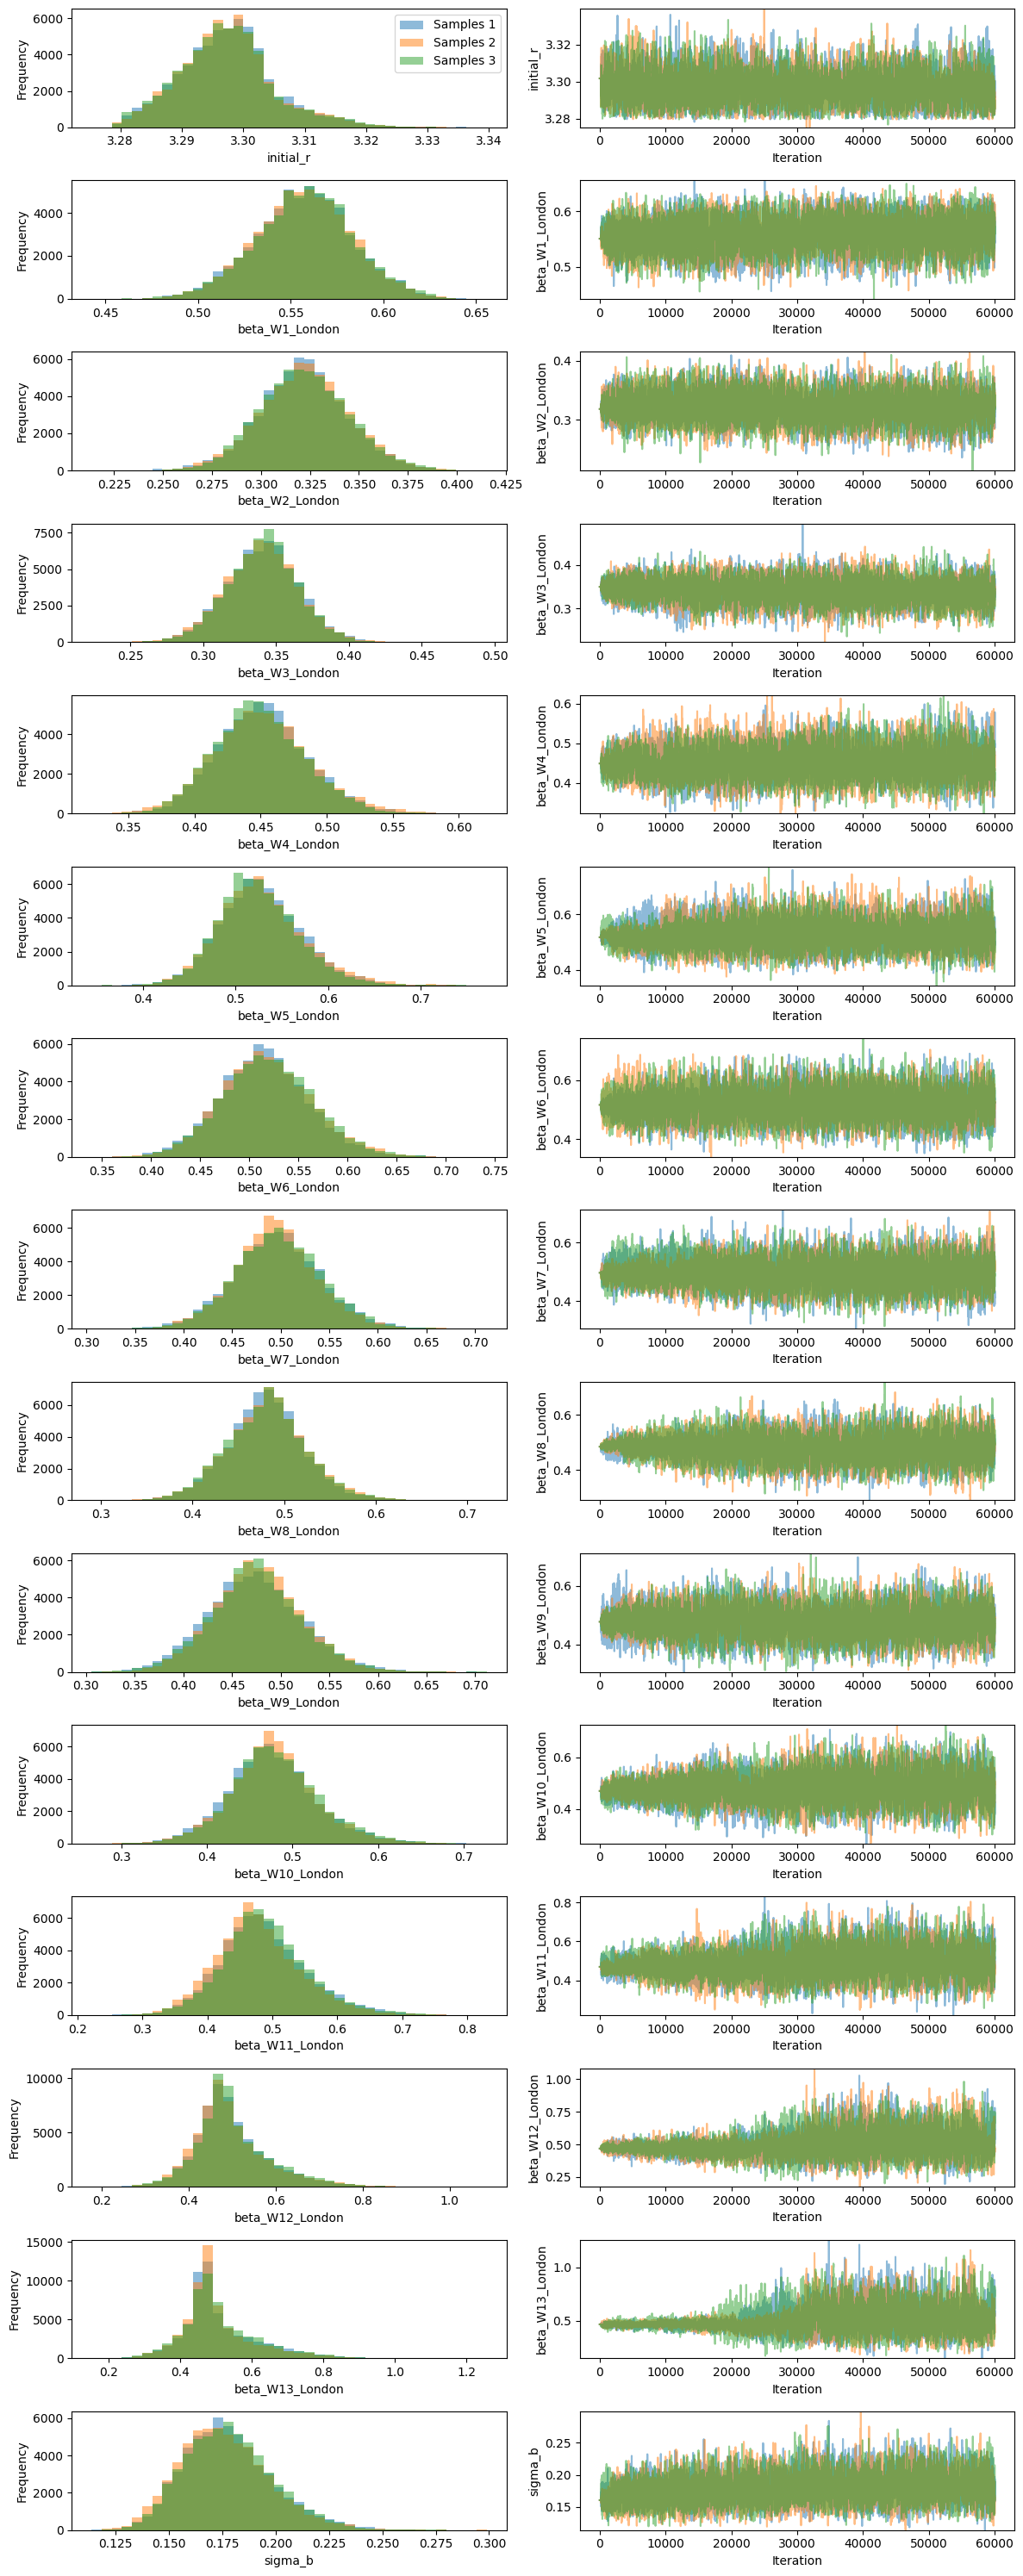

In [24]:
import pints.plot
 
# Plot histograms of the parameters inferred for London
param_names = ['initial_r']
param_names.extend(['beta_W{}_London'.format(i+1) for i in range(len(np.arange(44, len(times), 7)))])
param_names.extend(['sigma_b'])

pints.plot.trace(phe_exact_samples, parameter_names=param_names)
plt.show()

In [25]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
phe_exact_samples = phe_exact_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(phe_exact_samples))

[1.0027063  1.00095316 1.00255458 1.00565672 1.00215898 1.00347866
 1.00284528 1.00287607 1.00087318 1.00299675 1.00175063 1.00121626
 1.00087973 1.00201418 1.00216817]


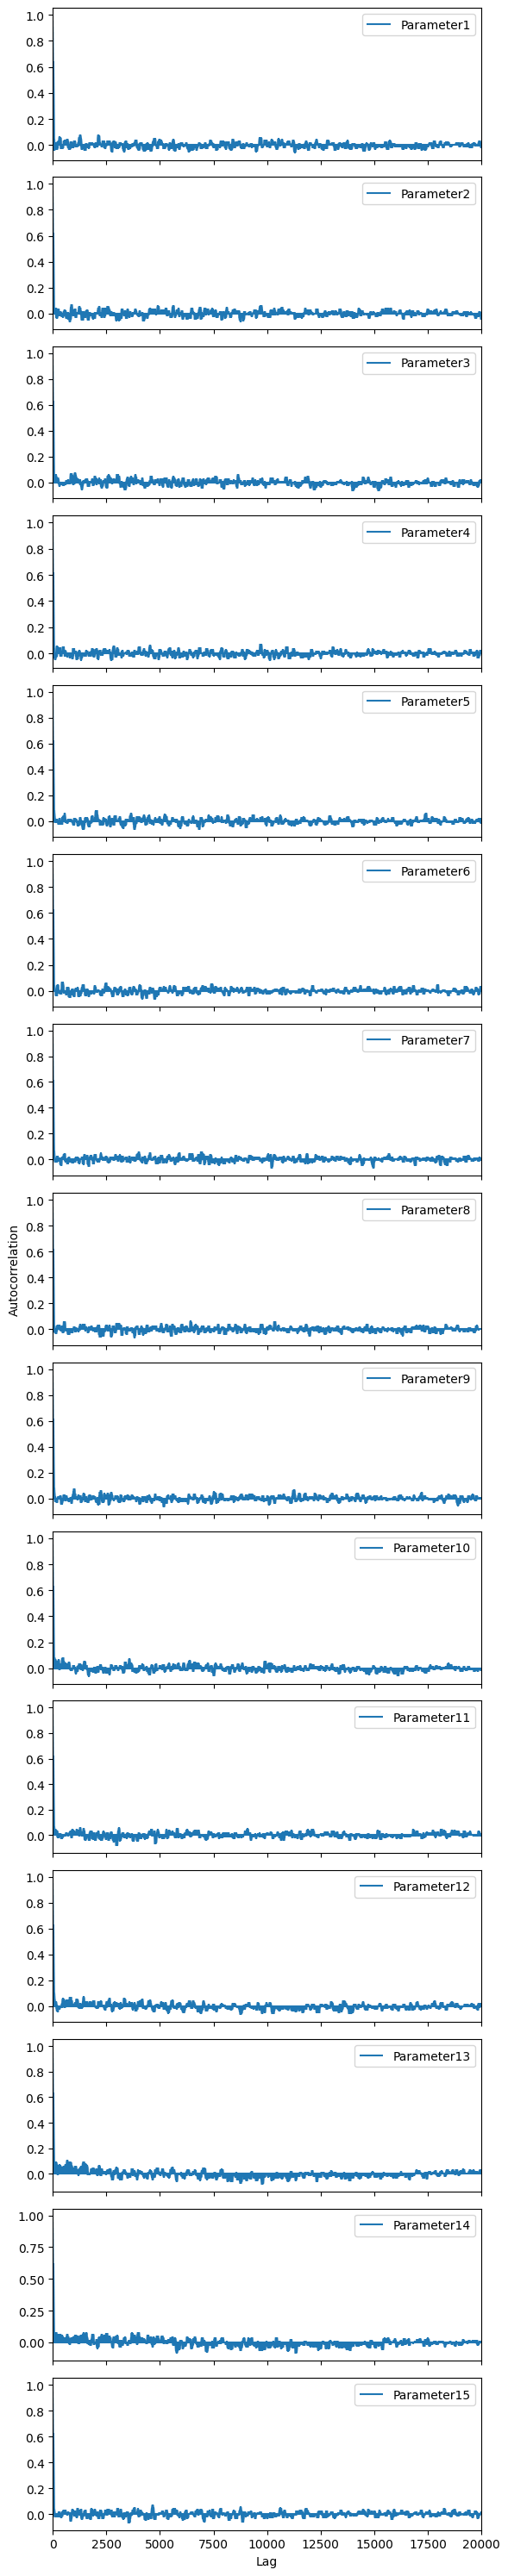

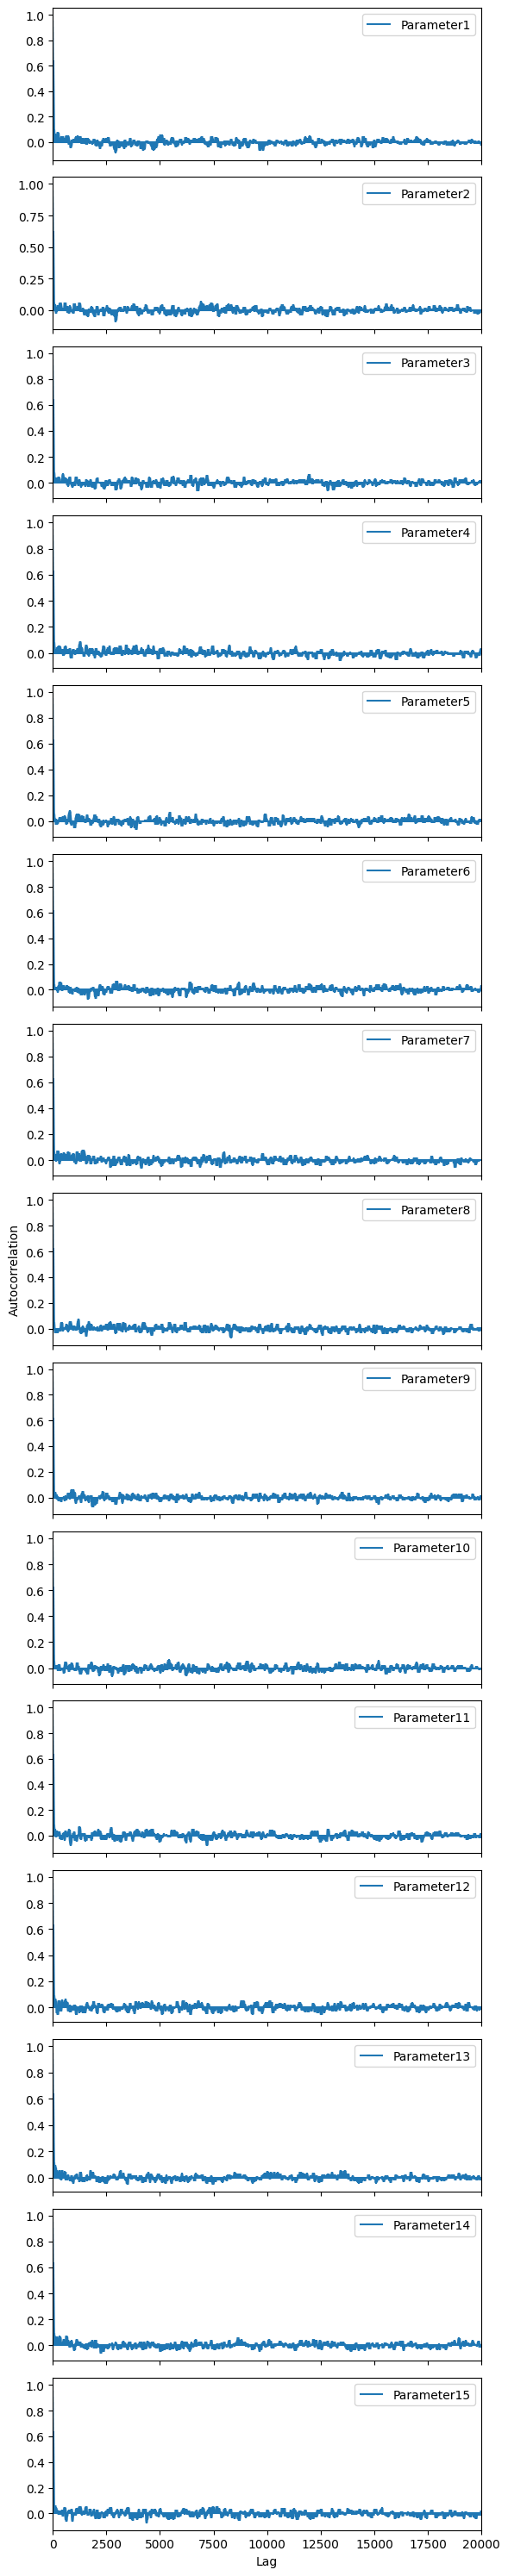

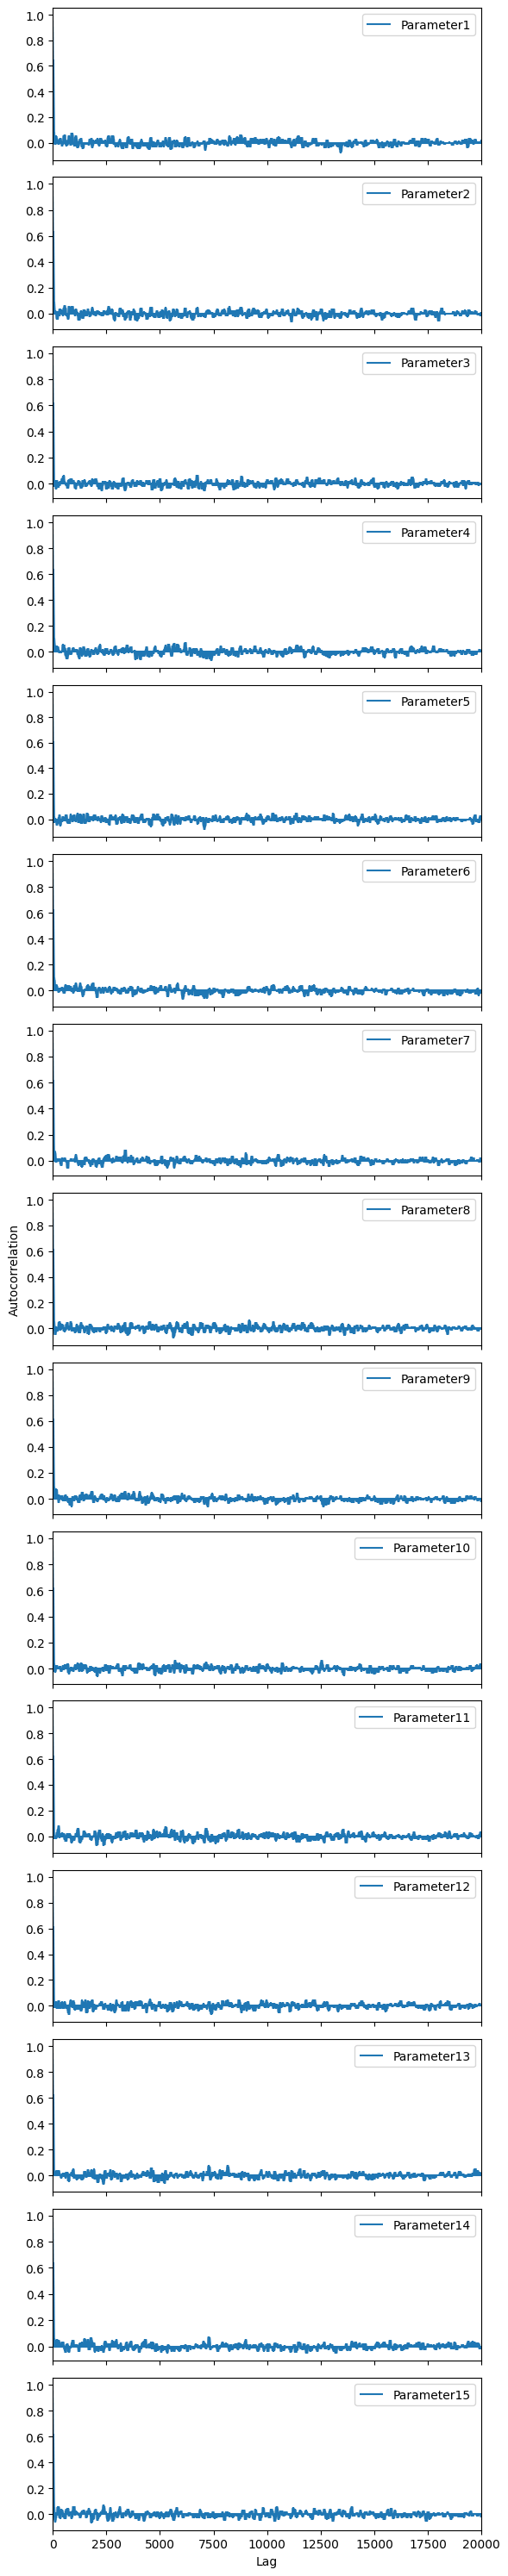

In [26]:
# Plot the autocorrelation for the three chains of parameters for South West
for phe_exact_sample in phe_exact_samples:
    pints.plot.autocorrelation(phe_exact_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

### Firstly save samples

In [ ]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = phe_exact_samples.shape

phe_exact_extended_samples = np.concatenate((phe_exact_samples[0], phe_exact_samples[1], phe_exact_samples[2]), axis=0)

np.savetxt('inference_data/PHE_Samples.csv', phe_exact_extended_samples, delimiter=',')

### PHE with on-time NPIs

In [84]:
phe_exact_extended_samples=np.loadtxt('inference_data/PHE_Samples.csv', delimiter=',')
total_samples = phe_exact_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

phe_exact_predicted_new_infec = []
phe_exact_predicted_deaths = []
phe_exact_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    phe_exact_reg_predicted_new_infec = []
    phe_exact_reg_predicted_deaths = []
    phe_exact_reg_predicted_reprod_num = []

    phe_model_exact_parameters.regional_parameters.region_index = r+1

    for params in phe_exact_extended_samples[::thinning, :]:
        phe_model_exact_parameters.regional_parameters.initial_r = [params[0]] * len(phe_model_exact.regions)
        LEN = len(np.arange(44, len(times), 7))

        betas = np.array(phe_model_exact_parameters.regional_parameters.betas)
        for r in range(len(regions)):
            for d, day in enumerate(np.arange(44, len(times), 7)):
                betas[r, day:(day+7)] = params[r*LEN+d+1]

        phe_model_exact_parameters.regional_parameters.betas = betas.tolist()

        phe_exact_r_fix = np.empty(len(times))
        phe_exact_model_reg_deaths_data = np.empty(len(times))

        phe_exact_m_fix = em.MultiTimesInfectivity(
            matrices_contact_exact, time_changes_contact_exact, regions, matrices_region_exact, time_changes_region_exact,
            phe_model_exact_parameters.regional_parameters.initial_r, phe_model_exact_parameters.disease_parameters.dI,
            phe_model_exact_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        phe_exact_model_output = phe_model_exact.simulate(phe_model_exact_parameters)
        
        phe_exact_age_model_reg_new_infections = phe_model_exact.new_infections(phe_exact_model_output)
        phe_exact_model_reg_new_infections = phe_exact_age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            phe_exact_r_fix[t] = phe_exact_m_fix.compute_reproduction_number(
                r+1, time, phe_exact_model_output[t, :len(age_groups)],
                temp_variation=phe_model_exact_parameters.regional_parameters.betas[r][t])
            phe_exact_model_reg_deaths_data[t] = np.sum(phe_model_exact.mean_deaths(
                fatality_ratio, time_to_death, t, phe_exact_age_model_reg_new_infections))

        phe_exact_reg_predicted_new_infec.append(phe_exact_model_reg_new_infections)
        phe_exact_reg_predicted_deaths.append(phe_exact_model_reg_deaths_data)
        phe_exact_reg_predicted_reprod_num.append(phe_exact_r_fix)

    phe_exact_reg_predicted_new_infec = np.array(phe_exact_reg_predicted_new_infec)
 
    phe_exact_predicted_new_infec.append(phe_exact_reg_predicted_new_infec)
    phe_exact_predicted_deaths.append(phe_exact_reg_predicted_deaths)
    phe_exact_predicted_reprod_num.append(phe_exact_reg_predicted_reprod_num)

phe_exact_predicted_new_infec = np.array(phe_exact_predicted_new_infec)
phe_exact_predicted_deaths = np.array(phe_exact_predicted_deaths)
phe_exact_predicted_reprod_num = np.array(phe_exact_predicted_reprod_num)


/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_366/3380055330.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  phe_exact_r_fix[t] = phe_exact_m_fix.compute_reproduction_number(


### PHE with delayed NPIs

In [85]:
phe_exact_extended_samples=np.loadtxt('inference_data/PHE_Samples.csv', delimiter=',')
total_samples = phe_exact_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

phe_delay_predicted_new_infec = []
phe_delay_predicted_deaths = []
phe_delay_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    phe_delay_reg_predicted_new_infec = []
    phe_delay_reg_predicted_deaths = []
    phe_delay_reg_predicted_reprod_num = []

    phe_model_delay_parameters.regional_parameters.region_index = r+1

    for params in phe_exact_extended_samples[::thinning, :]:
        phe_model_delay_parameters.regional_parameters.initial_r = [params[0]] * len(phe_model_delay.regions)
        
        phe_delay_r_fix = np.empty(len(times))
        phe_delay_model_reg_deaths_data = np.empty(len(times))

        phe_delay_m_fix = em.MultiTimesInfectivity(
            matrices_contact_delay, time_changes_contact_delay, regions, matrices_region_delay, time_changes_region_delay,
            phe_model_delay_parameters.regional_parameters.initial_r, phe_model_delay_parameters.disease_parameters.dI,
            phe_model_delay_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        phe_delay_model_output = phe_model_delay.simulate(phe_model_delay_parameters)

        phe_delay_age_model_reg_new_infections = phe_model_delay.new_infections(phe_delay_model_output)
        phe_delay_model_reg_new_infections = phe_delay_age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            phe_delay_r_fix[t] = phe_delay_m_fix.compute_reproduction_number(
                r+1, time, phe_delay_model_output[t, :len(age_groups)],
                temp_variation=phe_model_delay_parameters.regional_parameters.betas[r][t])
            phe_delay_model_reg_deaths_data[t] = np.sum(phe_model_delay.mean_deaths(
                fatality_ratio, time_to_death, t, phe_delay_age_model_reg_new_infections))

        phe_delay_reg_predicted_new_infec.append(phe_delay_model_reg_new_infections)
        phe_delay_reg_predicted_deaths.append(phe_delay_model_reg_deaths_data)
        phe_delay_reg_predicted_reprod_num.append(phe_delay_r_fix)

    phe_delay_reg_predicted_new_infec = np.array(phe_delay_reg_predicted_new_infec)

    phe_delay_predicted_new_infec.append(phe_delay_reg_predicted_new_infec)
    phe_delay_predicted_deaths.append(phe_delay_reg_predicted_deaths)
    phe_delay_predicted_reprod_num.append(phe_delay_reg_predicted_reprod_num)

phe_delay_predicted_new_infec = np.array(phe_delay_predicted_new_infec)
phe_delay_predicted_deaths = np.array(phe_delay_predicted_deaths)
phe_delay_predicted_reprod_num = np.array(phe_delay_predicted_reprod_num)

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_366/358133367.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  phe_delay_r_fix[t] = phe_delay_m_fix.compute_reproduction_number(


### PHE with early NPIs

In [86]:
phe_exact_extended_samples=np.loadtxt('inference_data/PHE_Samples.csv', delimiter=',')
total_samples = phe_exact_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

phe_early_predicted_new_infec = []
phe_early_predicted_deaths = []
phe_early_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    phe_early_reg_predicted_new_infec = []
    phe_early_reg_predicted_deaths = []
    phe_early_reg_predicted_reprod_num = []

    phe_model_early_parameters.regional_parameters.region_index = r+1

    for params in phe_exact_extended_samples[::thinning, :]:
        phe_model_early_parameters.regional_parameters.initial_r = [params[0]] * len(phe_model_early.regions)
        
        phe_early_r_fix = np.empty(len(times))
        phe_early_model_reg_deaths_data = np.empty(len(times))

        phe_early_m_fix = em.MultiTimesInfectivity(
            matrices_contact_early, time_changes_contact_early, regions, matrices_region_early, time_changes_region_early,
            phe_model_early_parameters.regional_parameters.initial_r, phe_model_early_parameters.disease_parameters.dI,
            phe_model_early_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        phe_early_model_output = phe_model_early.simulate(phe_model_early_parameters)

        phe_early_age_model_reg_new_infections = phe_model_early.new_infections(phe_early_model_output)
        phe_early_model_reg_new_infections = phe_early_age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            phe_early_r_fix[t] = phe_early_m_fix.compute_reproduction_number(
                r+1, time, phe_early_model_output[t, :len(age_groups)],
                temp_variation=phe_model_early_parameters.regional_parameters.betas[r][t])
            phe_early_model_reg_deaths_data[t] = np.sum(phe_model_early.mean_deaths(
                fatality_ratio, time_to_death, t, phe_early_age_model_reg_new_infections))

        phe_early_reg_predicted_new_infec.append(phe_early_model_reg_new_infections)
        phe_early_reg_predicted_deaths.append(phe_early_model_reg_deaths_data)
        phe_early_reg_predicted_reprod_num.append(phe_early_r_fix)

    phe_early_reg_predicted_new_infec = np.array(phe_early_reg_predicted_new_infec)

    phe_early_predicted_new_infec.append(phe_early_reg_predicted_new_infec)
    phe_early_predicted_deaths.append(phe_early_reg_predicted_deaths)
    phe_early_predicted_reprod_num.append(phe_early_reg_predicted_reprod_num)

phe_early_predicted_new_infec = np.array(phe_early_predicted_new_infec)
phe_early_predicted_deaths = np.array(phe_early_predicted_deaths)
phe_early_predicted_reprod_num = np.array(phe_early_predicted_reprod_num)

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_366/3909989707.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  phe_early_r_fix[t] = phe_early_m_fix.compute_reproduction_number(


### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### PHE with on-time NPIs

In [87]:
# Set up traces to plot
phe_exact_new_infec_mean = []
phe_exact_deaths_mean = []
phe_exact_reprod_num_mean = []

phe_exact_new_infec_upper = []
phe_exact_deaths_upper = []
phe_exact_reprod_num_upper = []

phe_exact_new_infec_lower = []
phe_exact_deaths_lower = []
phe_exact_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    phe_exact_new_infec_mean.append(np.mean(phe_exact_predicted_new_infec[r,:,:], axis=0))
    phe_exact_deaths_mean.append(np.mean(phe_exact_predicted_deaths[r,:,:], axis=0))
    phe_exact_reprod_num_mean.append(np.mean(phe_exact_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    phe_exact_new_infec_upper.append(np.quantile(phe_exact_predicted_new_infec[r,:,:], 0.975, axis=0))
    phe_exact_deaths_upper.append(np.quantile(phe_exact_predicted_deaths[r,:,:], 0.975, axis=0))
    phe_exact_reprod_num_upper.append(np.quantile(phe_exact_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    phe_exact_new_infec_lower.append(np.quantile(phe_exact_predicted_new_infec[r,:,:], 0.025, axis=0))
    phe_exact_deaths_lower.append(np.quantile(phe_exact_predicted_deaths[r,:,:], 0.025, axis=0))
    phe_exact_reprod_num_lower.append(np.quantile(phe_exact_predicted_reprod_num[r,:,:], 0.025, axis=0))

### PHE with delayed contacts

In [88]:
# Set up traces to plot
phe_delay_new_infec_mean = []
phe_delay_deaths_mean = []
phe_delay_reprod_num_mean = []

phe_delay_new_infec_upper = []
phe_delay_deaths_upper = []
phe_delay_reprod_num_upper = []

phe_delay_new_infec_lower = []
phe_delay_deaths_lower = []
phe_delay_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    phe_delay_new_infec_mean.append(np.mean(phe_delay_predicted_new_infec[r,:,:], axis=0))
    phe_delay_deaths_mean.append(np.mean(phe_delay_predicted_deaths[r,:,:], axis=0))
    phe_delay_reprod_num_mean.append(np.mean(phe_delay_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    phe_delay_new_infec_upper.append(np.quantile(phe_delay_predicted_new_infec[r,:,:], 0.975, axis=0))
    phe_delay_deaths_upper.append(np.quantile(phe_delay_predicted_deaths[r,:,:], 0.975, axis=0))
    phe_delay_reprod_num_upper.append(np.quantile(phe_delay_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    phe_delay_new_infec_lower.append(np.quantile(phe_delay_predicted_new_infec[r,:,:], 0.025, axis=0))
    phe_delay_deaths_lower.append(np.quantile(phe_delay_predicted_deaths[r,:,:], 0.025, axis=0))
    phe_delay_reprod_num_lower.append(np.quantile(phe_delay_predicted_reprod_num[r,:,:], 0.025, axis=0))

### PHE with early NPIs

In [89]:
# Set up traces to plot
phe_early_new_infec_mean = []
phe_early_deaths_mean = []
phe_early_reprod_num_mean = []

phe_early_new_infec_upper = []
phe_early_deaths_upper = []
phe_early_reprod_num_upper = []

phe_early_new_infec_lower = []
phe_early_deaths_lower = []
phe_early_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    phe_early_new_infec_mean.append(np.mean(phe_early_predicted_new_infec[r,:,:], axis=0))
    phe_early_deaths_mean.append(np.mean(phe_early_predicted_deaths[r,:,:], axis=0))
    phe_early_reprod_num_mean.append(np.mean(phe_early_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    phe_early_new_infec_upper.append(np.quantile(phe_early_predicted_new_infec[r,:,:], 0.975, axis=0))
    phe_early_deaths_upper.append(np.quantile(phe_early_predicted_deaths[r,:,:], 0.975, axis=0))
    phe_early_reprod_num_upper.append(np.quantile(phe_early_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    phe_early_new_infec_lower.append(np.quantile(phe_early_predicted_new_infec[r,:,:], 0.025, axis=0))
    phe_early_deaths_lower.append(np.quantile(phe_early_predicted_deaths[r,:,:], 0.025, axis=0))
    phe_early_reprod_num_lower.append(np.quantile(phe_early_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Roche (with on-time NPIs)

In [31]:
# Set random seed
np.random.seed(28)

In [32]:
# Initialise inference for the model
roche_inference_exact = em.inference.RocheSEIRInfer(roche_model_exact)

# Add model, death, tests and NPIs data to the inference structure
roche_inference_exact.read_model_data(susceptibles, infectives)
roche_inference_exact.read_deaths_data(deaths_data, deaths_times)
roche_inference_exact.read_serology_data(tests, positives_data, serology_times, sens, spec)
roche_inference_exact.read_npis_data(max_levels_npi, targeted_npi, general_npi_exact, reg_levels_npi_exact, time_changes_npi_exact, time_changes_flag_exact)

# Run inference structure
roche_exact_samples = roche_inference_exact.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -14739.6  -14739.6    0:00.4
1     12    -12864.67 -12864.67   0:00.7
2     18    -9893.751 -9893.751   0:01.1
3     24    -9893.751 -10890.73   0:01.4
20    126   -5701.166 -5701.166   0:06.4
40    246   -3744.263 -3744.282   0:13.9
60    366   -3744.258 -3744.258   0:21.7
80    486   -3744.258 -3744.258   0:29.5
100   606   -3744.258 -3744.258   0:37.3
120   726   -3744.258 -3744.258   0:45.2
135   810   -3744.258 -3744.258   0:50.7
Halting: No significant change for 100 iterations.
[0.03178126 0.94732467] -3744.2577323494675
Optimisation phase is finished.
Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in parallel with 3 worker processess.
Iter. Eval.  Accept.   Accept.   Accept.   Time    
0     3       0         0         0          0:01.2
1     6       0         

### Quality check of the inference procedure

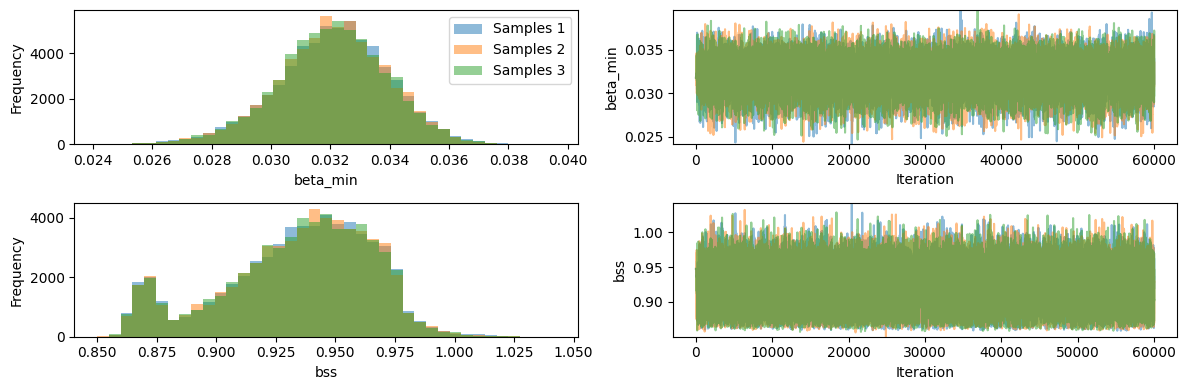

In [33]:
import pints.plot

# Plot histograms of the parameters inferred for South West
# param_names = ['Initial Pss']
# for age in model.age_groups:
#     param_names.append('kR_{}'.format(age))

# for age in model.age_groups:
#     param_names.append('Pa_{}'.format(age))
param_names=['beta_min', 'bss']

pints.plot.trace(roche_exact_samples, parameter_names=param_names)
plt.show()

In [34]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
roche_exact_samples = roche_exact_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(roche_exact_samples))

[1.00035384 1.00020418]


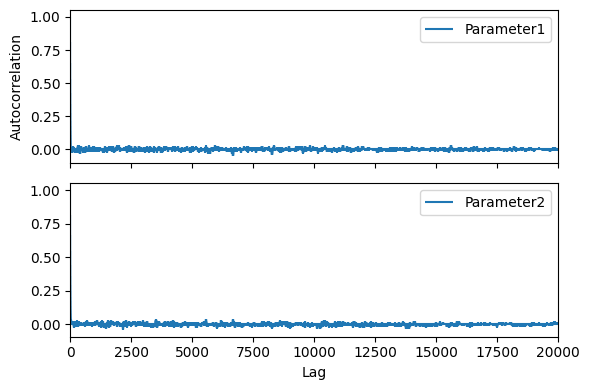

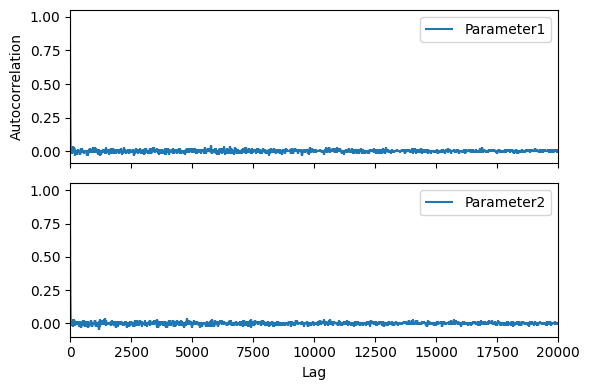

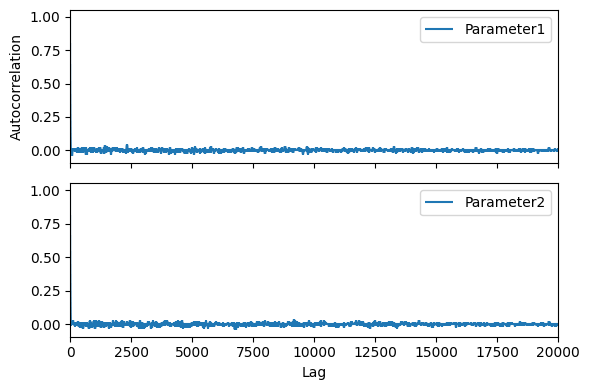

In [35]:
# Plot the autocorrelation for the three chains of parameters for South West
for roche_exact_sample in roche_exact_samples:
    pints.plot.autocorrelation(roche_exact_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

### Firstly save samples

In [ ]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = roche_exact_samples.shape

roche_exact_extended_samples = np.concatenate((roche_exact_samples[0], roche_exact_samples[1], roche_exact_samples[2]), axis=0)

np.savetxt('inference_data/Roche_Samples.csv', roche_exact_extended_samples, delimiter=',')

### Roche with on-time NPIs

In [90]:
roche_exact_extended_samples=np.loadtxt('inference_data/Roche_Samples.csv', delimiter=',')
total_samples = roche_exact_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

roche_exact_predicted_new_infec = []
roche_exact_predicted_deaths = []
roche_exact_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    roche_exact_reg_predicted_new_infec = []
    roche_exact_reg_predicted_deaths = []
    roche_exact_reg_predicted_reprod_num = []

    roche_model_exact_parameters.simulation_parameters.region_index = r+1

    for params in roche_exact_extended_samples[::thinning, :]:
        roche_model_exact_parameters.transmission_parameters.beta_min = params[0]
        roche_model_exact_parameters.transmission_parameters.bss = params[1]
        
        roche_exact_r_fix = np.empty(len(times))
        roche_exact_model_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        roche_exact_model_output = roche_model_exact.simulate(roche_model_exact_parameters)
        
        roche_exact_age_model_reg_new_infections = roche_model_exact.new_infections(roche_exact_model_output)
        roche_exact_model_reg_new_infections = roche_exact_age_model_reg_new_infections.sum(axis=1)

        roche_exact_age_model_reg_new_deaths = roche_model_exact.new_deaths(roche_exact_model_output)
        
        roche_model_exact.compute_transition_matrix()
        for t, time in enumerate(times):
            roche_exact_r_fix[t] = roche_model_exact.compute_rt_trajectory(roche_exact_model_output, t)
            roche_exact_model_reg_deaths_data[t] = np.sum(roche_model_exact.mean_deaths(
                t, roche_exact_age_model_reg_new_deaths))

        roche_exact_reg_predicted_new_infec.append(roche_exact_model_reg_new_infections)
        roche_exact_reg_predicted_deaths.append(roche_exact_model_reg_deaths_data)
        roche_exact_reg_predicted_reprod_num.append(roche_exact_r_fix)

    roche_exact_reg_predicted_new_infec = np.array(roche_exact_reg_predicted_new_infec)
 
    roche_exact_predicted_new_infec.append(roche_exact_reg_predicted_new_infec)
    roche_exact_predicted_deaths.append(roche_exact_reg_predicted_deaths)
    roche_exact_predicted_reprod_num.append(roche_exact_reg_predicted_reprod_num)

roche_exact_predicted_new_infec = np.array(roche_exact_predicted_new_infec)
roche_exact_predicted_deaths = np.array(roche_exact_predicted_deaths)
roche_exact_predicted_reprod_num = np.array(roche_exact_predicted_reprod_num)


### Roche with delayed NPIs

In [91]:
roche_exact_extended_samples=np.loadtxt('inference_data/Roche_Samples.csv', delimiter=',')
total_samples = roche_exact_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

roche_delay_predicted_new_infec = []
roche_delay_predicted_deaths = []
roche_delay_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    roche_delay_reg_predicted_new_infec = []
    roche_delay_reg_predicted_deaths = []
    roche_delay_reg_predicted_reprod_num = []

    roche_model_delay_parameters.simulation_parameters.region_index = r+1

    for params in roche_exact_extended_samples[::thinning, :]:
        roche_model_delay_parameters.transmission_parameters.beta_min = params[0]
        roche_model_delay_parameters.transmission_parameters.bss = params[1]
        
        roche_delay_r_fix = np.empty(len(times))
        roche_delay_model_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        roche_delay_model_output = roche_model_delay.simulate(roche_model_delay_parameters)
        
        roche_delay_age_model_reg_new_infections = roche_model_delay.new_infections(roche_delay_model_output)
        roche_delay_model_reg_new_infections = roche_delay_age_model_reg_new_infections.sum(axis=1)

        roche_delay_age_model_reg_new_deaths = roche_model_delay.new_deaths(roche_delay_model_output)
        
        roche_model_delay.compute_transition_matrix()
        for t, time in enumerate(times):
            roche_delay_r_fix[t] = roche_model_delay.compute_rt_trajectory(roche_delay_model_output, t)
            roche_delay_model_reg_deaths_data[t] = np.sum(roche_model_delay.mean_deaths(
                t, roche_delay_age_model_reg_new_deaths))

        roche_delay_reg_predicted_new_infec.append(roche_delay_model_reg_new_infections)
        roche_delay_reg_predicted_deaths.append(roche_delay_model_reg_deaths_data)
        roche_delay_reg_predicted_reprod_num.append(roche_delay_r_fix)

    roche_delay_reg_predicted_new_infec = np.array(roche_delay_reg_predicted_new_infec)
 
    roche_delay_predicted_new_infec.append(roche_delay_reg_predicted_new_infec)
    roche_delay_predicted_deaths.append(roche_delay_reg_predicted_deaths)
    roche_delay_predicted_reprod_num.append(roche_delay_reg_predicted_reprod_num)

roche_delay_predicted_new_infec = np.array(roche_delay_predicted_new_infec)
roche_delay_predicted_deaths = np.array(roche_delay_predicted_deaths)
roche_delay_predicted_reprod_num = np.array(roche_delay_predicted_reprod_num)


### Roche with early NPIs

In [92]:
roche_exact_extended_samples=np.loadtxt('inference_data/Roche_Samples.csv', delimiter=',')
total_samples = roche_exact_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

roche_early_predicted_new_infec = []
roche_early_predicted_deaths = []
roche_early_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    roche_early_reg_predicted_new_infec = []
    roche_early_reg_predicted_deaths = []
    roche_early_reg_predicted_reprod_num = []

    roche_model_early_parameters.simulation_parameters.region_index = r+1

    for params in roche_exact_extended_samples[::thinning, :]:
        roche_model_early_parameters.transmission_parameters.beta_min = params[0]
        roche_model_early_parameters.transmission_parameters.bss = params[1]
        
        roche_early_r_fix = np.empty(len(times))
        roche_early_model_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        roche_early_model_output = roche_model_early.simulate(roche_model_early_parameters)
        
        roche_early_age_model_reg_new_infections = roche_model_early.new_infections(roche_early_model_output)
        roche_early_model_reg_new_infections = roche_early_age_model_reg_new_infections.sum(axis=1)

        roche_early_age_model_reg_new_deaths = roche_model_early.new_deaths(roche_early_model_output)
        
        roche_model_early.compute_transition_matrix()
        for t, time in enumerate(times):
            roche_early_r_fix[t] = roche_model_early.compute_rt_trajectory(roche_early_model_output, t)
            roche_early_model_reg_deaths_data[t] = np.sum(roche_model_early.mean_deaths(
                t, roche_early_age_model_reg_new_deaths))

        roche_early_reg_predicted_new_infec.append(roche_early_model_reg_new_infections)
        roche_early_reg_predicted_deaths.append(roche_early_model_reg_deaths_data)
        roche_early_reg_predicted_reprod_num.append(roche_early_r_fix)

    roche_early_reg_predicted_new_infec = np.array(roche_early_reg_predicted_new_infec)
 
    roche_early_predicted_new_infec.append(roche_early_reg_predicted_new_infec)
    roche_early_predicted_deaths.append(roche_early_reg_predicted_deaths)
    roche_early_predicted_reprod_num.append(roche_early_reg_predicted_reprod_num)

roche_early_predicted_new_infec = np.array(roche_early_predicted_new_infec)
roche_early_predicted_deaths = np.array(roche_early_predicted_deaths)
roche_early_predicted_reprod_num = np.array(roche_early_predicted_reprod_num)


### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### Roche with on-time NPIs

In [93]:
# Set up traces to plot
roche_exact_new_infec_mean = []
roche_exact_deaths_mean = []
roche_exact_reprod_num_mean = []

roche_exact_new_infec_upper = []
roche_exact_deaths_upper = []
roche_exact_reprod_num_upper = []

roche_exact_new_infec_lower = []
roche_exact_deaths_lower = []
roche_exact_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    roche_exact_new_infec_mean.append(np.mean(roche_exact_predicted_new_infec[r,:,:], axis=0))
    roche_exact_deaths_mean.append(np.mean(roche_exact_predicted_deaths[r,:,:], axis=0))
    roche_exact_reprod_num_mean.append(np.mean(roche_exact_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    roche_exact_new_infec_upper.append(np.quantile(roche_exact_predicted_new_infec[r,:,:], 0.975, axis=0))
    roche_exact_deaths_upper.append(np.quantile(roche_exact_predicted_deaths[r,:,:], 0.975, axis=0))
    roche_exact_reprod_num_upper.append(np.quantile(roche_exact_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    roche_exact_new_infec_lower.append(np.quantile(roche_exact_predicted_new_infec[r,:,:], 0.025, axis=0))
    roche_exact_deaths_lower.append(np.quantile(roche_exact_predicted_deaths[r,:,:], 0.025, axis=0))
    roche_exact_reprod_num_lower.append(np.quantile(roche_exact_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Roche with delayed NPIs

In [94]:
# Set up traces to plot
roche_delay_new_infec_mean = []
roche_delay_deaths_mean = []
roche_delay_reprod_num_mean = []

roche_delay_new_infec_upper = []
roche_delay_deaths_upper = []
roche_delay_reprod_num_upper = []

roche_delay_new_infec_lower = []
roche_delay_deaths_lower = []
roche_delay_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    roche_delay_new_infec_mean.append(np.mean(roche_delay_predicted_new_infec[r,:,:], axis=0))
    roche_delay_deaths_mean.append(np.mean(roche_delay_predicted_deaths[r,:,:], axis=0))
    roche_delay_reprod_num_mean.append(np.mean(roche_delay_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    roche_delay_new_infec_upper.append(np.quantile(roche_delay_predicted_new_infec[r,:,:], 0.975, axis=0))
    roche_delay_deaths_upper.append(np.quantile(roche_delay_predicted_deaths[r,:,:], 0.975, axis=0))
    roche_delay_reprod_num_upper.append(np.quantile(roche_delay_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    roche_delay_new_infec_lower.append(np.quantile(roche_delay_predicted_new_infec[r,:,:], 0.025, axis=0))
    roche_delay_deaths_lower.append(np.quantile(roche_delay_predicted_deaths[r,:,:], 0.025, axis=0))
    roche_delay_reprod_num_lower.append(np.quantile(roche_delay_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Roche with early NPIs

In [95]:
# Set up traces to plot
roche_early_new_infec_mean = []
roche_early_deaths_mean = []
roche_early_reprod_num_mean = []

roche_early_new_infec_upper = []
roche_early_deaths_upper = []
roche_early_reprod_num_upper = []

roche_early_new_infec_lower = []
roche_early_deaths_lower = []
roche_early_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    roche_early_new_infec_mean.append(np.mean(roche_early_predicted_new_infec[r,:,:], axis=0))
    roche_early_deaths_mean.append(np.mean(roche_early_predicted_deaths[r,:,:], axis=0))
    roche_early_reprod_num_mean.append(np.mean(roche_early_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    roche_early_new_infec_upper.append(np.quantile(roche_early_predicted_new_infec[r,:,:], 0.975, axis=0))
    roche_early_deaths_upper.append(np.quantile(roche_early_predicted_deaths[r,:,:], 0.975, axis=0))
    roche_early_reprod_num_upper.append(np.quantile(roche_early_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    roche_early_new_infec_lower.append(np.quantile(roche_early_predicted_new_infec[r,:,:], 0.025, axis=0))
    roche_early_deaths_lower.append(np.quantile(roche_early_predicted_deaths[r,:,:], 0.025, axis=0))
    roche_early_reprod_num_lower.append(np.quantile(roche_early_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Warwick Household (with on time NPIs)

In [40]:
# Set random seed
np.random.seed(28)

In [41]:
# Initialise inference for the model
warwick_inference_exact = em.inference.WarwickSEIRInfer(warwick_model_exact)

# Add model, death, tests and NPIs data to the inference structure
warwick_inference_exact.read_model_data(
    [susceptibles], 
    [stack_age_groups(pop, (200 * extended_infectives_prop)).astype(int).tolist()])
warwick_inference_exact.read_extended_population_structure(extended_susceptibles, extended_infectives_prop)
warwick_inference_exact.read_extended_contact_matrices(
    extended_house_cont_mat, extended_school_cont_mat,
    extended_work_cont_mat, extended_other_cont_mat)
warwick_inference_exact.read_deaths_data(deaths_data, deaths_times)
warwick_inference_exact.read_delay_data(pDtoH, dDtoH, pHtoDeath, dHtoDeath)
warwick_inference_exact.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run inference structure
warwick_exact_samples = warwick_inference_exact.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9


/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Iter. Eval. Best      Current   Time    
0     9     -47881.91 -47881.91   0:00.6
1     18    -47881.91 -48327.2    0:00.9


/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)


2     27    -47007.8  -47007.8    0:01.7
3     36    -47007.8  -inf        0:01.7
20    189   -36894.04 -37994.58   0:11.6
40    369   -2663.99  -2663.99    0:28.7
60    549   -2085.478 -4011.919   0:40.9
80    729   -1414.326 -1427.639   1:03.1
100   909   -1393.701 -1393.753   1:27.7
120   1089  -1392.199 -1392.385   1:51.3
140   1269  -1391.631 -1391.631   2:14.3
160   1449  -1391.356 -1391.396   2:37.9
180   1629  -1391.051 -1391.123   3:00.0
200   1809  -1389.503 -1389.503   3:24.5
220   1989  -1386.743 -1386.743   3:52.3
240   2169  -1379.224 -1379.224   4:22.3
260   2349  -1375.994 -1376.517   4:45.8
280   2529  -1371.741 -1371.741   5:11.0
300   2709  -1356.493 -1357.889   5:32.4
320   2889  -1338.156 -1339.809   5:54.5
340   3069  -1335.672 -1336.132   6:16.9
360   3249  -1333.85  -1333.85    6:38.9
380   3429  -1333.787 -1333.791   6:57.0
400   3609  -1333.76  -1333.768   7:18.4
420   3789  -1333.75  -1333.753   7:38.5
440   3969  -1333.746 -1333.746   7:59.7
460   4149  -133

### Quality check of the inference procedure

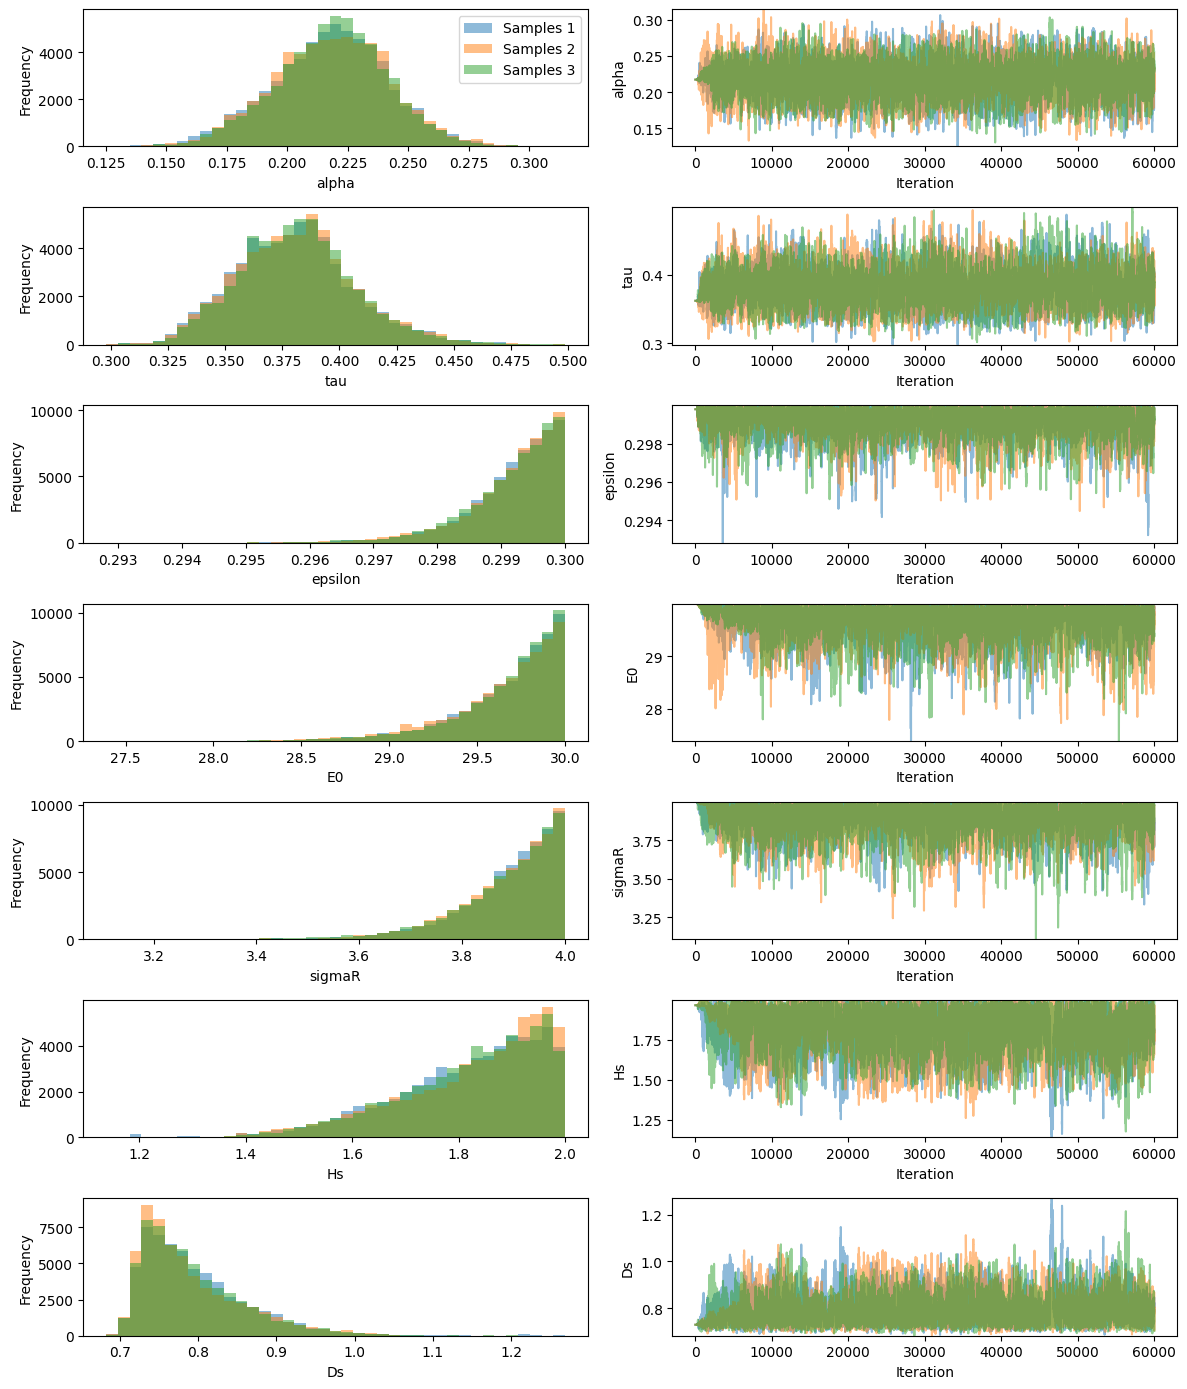

In [42]:
import pints.plot

# Plot histograms of the parameters inferred for South West
param_names=['tau', 'gamma']

pints.plot.trace(warwick_exact_samples, parameter_names=param_names)
plt.show()

In [43]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
warwick_exact_samples = warwick_exact_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(warwick_exact_samples))

[1.00265277 1.00489453 1.0019891  1.00689547 1.00358938 1.00568198
 1.00624403]


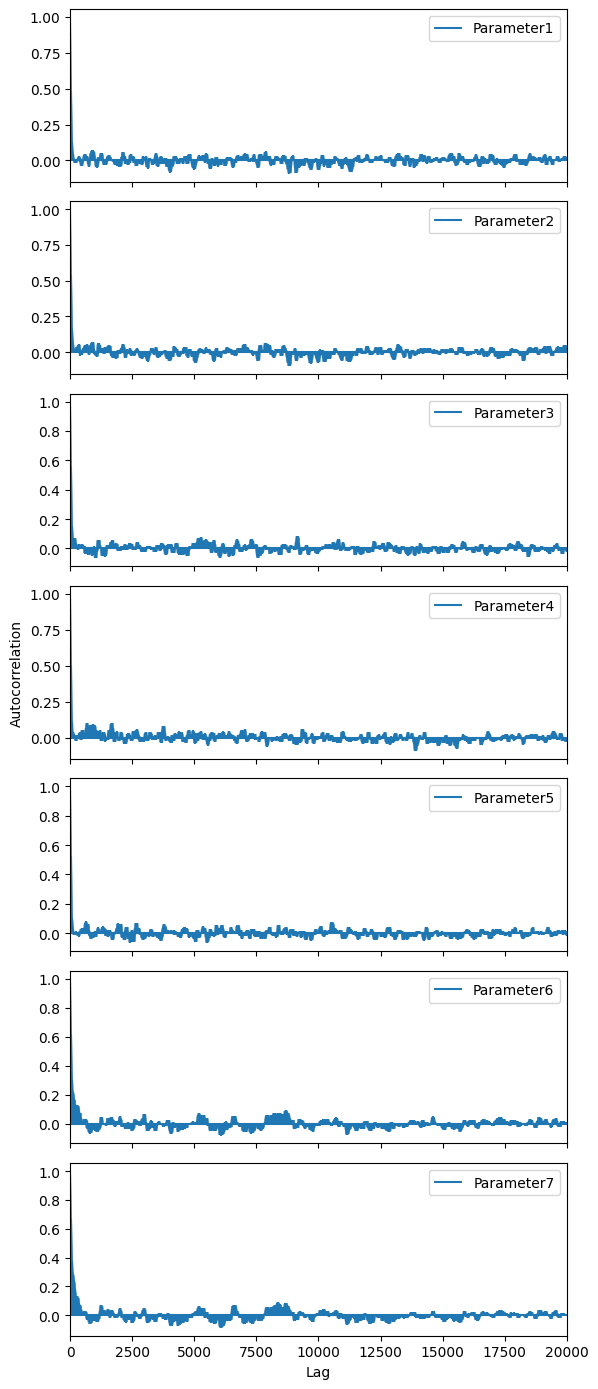

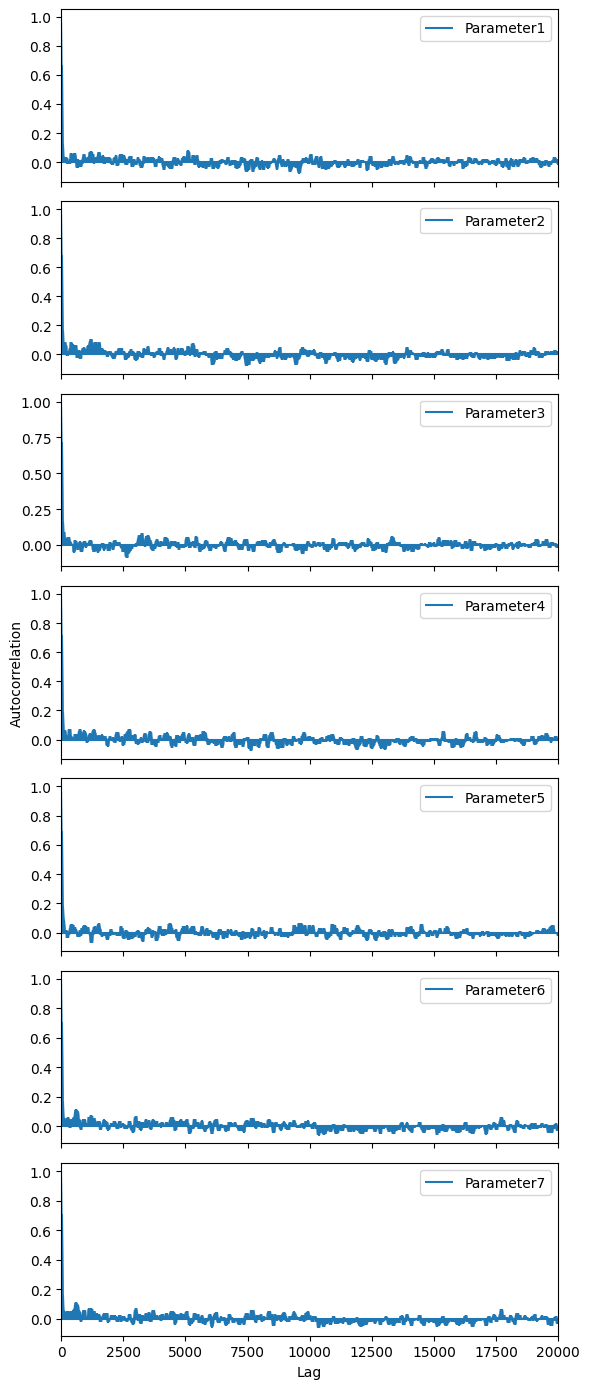

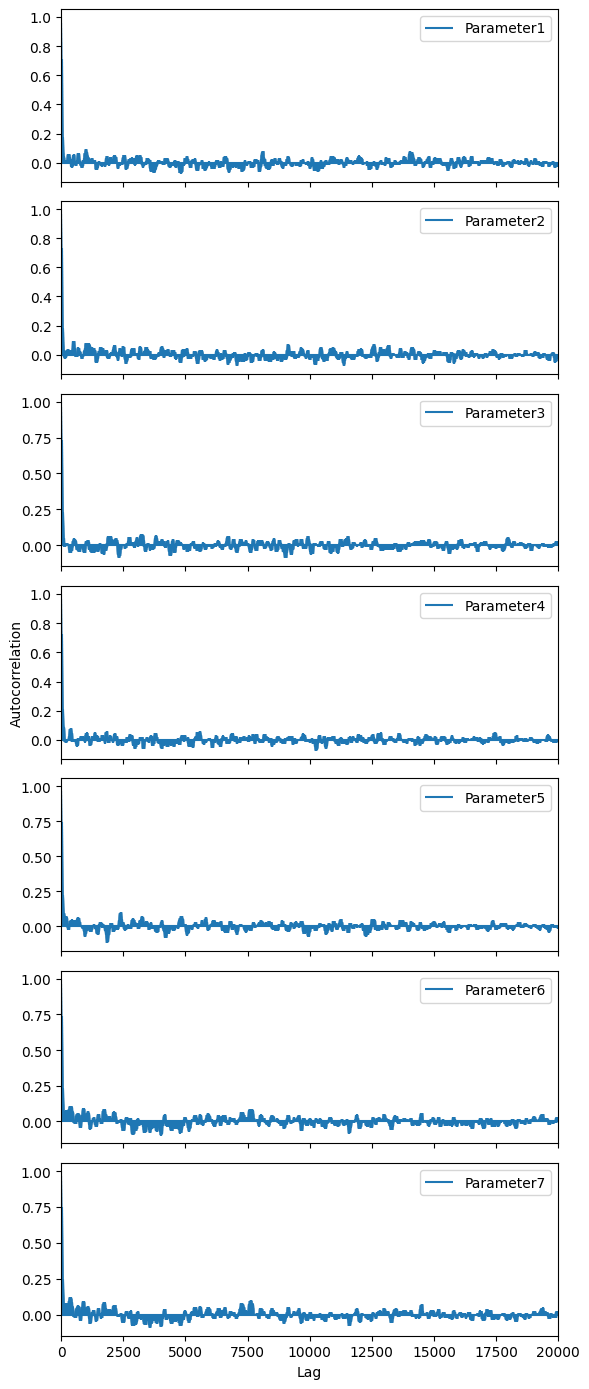

In [44]:
# Plot the autocorrelation for the three chains of parameters for South West
for warwick_exact_sample in warwick_exact_samples:
    pints.plot.autocorrelation(warwick_exact_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths

### Firstly save samples

In [ ]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = warwick_exact_samples.shape

warwick_exact_extended_samples = np.concatenate((warwick_exact_samples[0], warwick_exact_samples[1], warwick_exact_samples[2]), axis=0)

np.savetxt('inference_data/Warwick_Samples.csv', warwick_exact_extended_samples, delimiter=',')

### Warwick Household with on-time NPIs

In [97]:
warwick_exact_extended_samples = np.loadtxt('inference_data/Warwick_Samples.csv', delimiter=',')
total_samples = warwick_exact_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

warwick_exact_predicted_new_infec = []
warwick_exact_predicted_deaths = []
warwick_exact_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    warwick_exact_reg_predicted_new_infec = []
    warwick_exact_reg_predicted_deaths = []
    warwick_exact_reg_predicted_reprod_num = []

    warwick_model_exact_parameters.simulation_parameters.region_index = r + 1

    for params in warwick_exact_extended_samples[::thinning, :]:
        warwick_model_exact_parameters.disease_parameters.tau = params[0]
        warwick_model_exact_parameters.transmission_parameters.gamma = params[1]
        
        warwick_exact_r_fix = np.empty(len(times))
        warwick_exact_model_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        warwick_exact_model_output = warwick_model_exact.simulate(warwick_model_exact_parameters)

        warwick_exact_age_model_reg_new_infections = warwick_model_exact.new_infections(warwick_exact_model_output)
        warwick_exact_model_reg_new_infections = warwick_exact_age_model_reg_new_infections.sum(axis=1)

        warwick_exact_age_model_reg_new_hosp = warwick_model_exact.new_hospitalisations(warwick_exact_age_model_reg_new_infections, pDtoH, dDtoH)
        warwick_exact_model_reg_new_hosp = warwick_exact_age_model_reg_new_hosp.sum(axis=1)

        warwick_exact_age_model_reg_new_deaths = warwick_model_exact.new_deaths(warwick_exact_age_model_reg_new_hosp, pHtoDeath, dHtoDeath)

        warwick_model_exact.compute_transition_matrix()
        for t, time in enumerate(times):
            warwick_exact_r_fix[t] = warwick_model_exact.compute_rt_trajectory(warwick_exact_model_output, t)
            warwick_exact_model_reg_deaths_data[t] = np.sum(warwick_model_exact.mean_deaths(t, warwick_exact_age_model_reg_new_deaths))
        
        warwick_exact_reg_predicted_new_infec.append(warwick_exact_model_reg_new_infections)
        warwick_exact_reg_predicted_deaths.append(warwick_exact_model_reg_deaths_data)
        warwick_exact_reg_predicted_reprod_num.append(warwick_exact_r_fix)

    warwick_exact_reg_predicted_new_infec = np.array(warwick_exact_reg_predicted_new_infec)

    warwick_exact_predicted_new_infec.append(warwick_exact_reg_predicted_new_infec)
    warwick_exact_predicted_deaths.append(warwick_exact_reg_predicted_deaths)
    warwick_exact_predicted_reprod_num.append(warwick_exact_reg_predicted_reprod_num)

warwick_exact_predicted_new_infec = np.array(warwick_exact_predicted_new_infec)
warwick_exact_predicted_deaths = np.array(warwick_exact_predicted_deaths)
warwick_exact_predicted_reprod_num = np.array(warwick_exact_predicted_reprod_num)


### Warwick Household with delayed NPIs

In [98]:
warwick_exact_extended_samples = np.loadtxt('inference_data/Warwick_Samples.csv', delimiter=',')
total_samples = warwick_exact_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

warwick_delay_predicted_new_infec = []
warwick_delay_predicted_deaths = []
warwick_delay_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    warwick_delay_reg_predicted_new_infec = []
    warwick_delay_reg_predicted_deaths = []
    warwick_delay_reg_predicted_reprod_num = []

    warwick_model_delay_parameters.simulation_parameters.region_index = r + 1

    for params in warwick_exact_extended_samples[::thinning, :]:
        warwick_model_delay_parameters.disease_parameters.tau = params[0]
        warwick_model_delay_parameters.transmission_parameters.gamma = params[1]
        
        warwick_delay_r_fix = np.empty(len(times))
        warwick_delay_model_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        warwick_delay_model_output = warwick_model_delay.simulate(warwick_model_delay_parameters)

        warwick_delay_age_model_reg_new_infections = warwick_model_delay.new_infections(warwick_delay_model_output)
        warwick_delay_model_reg_new_infections = warwick_delay_age_model_reg_new_infections.sum(axis=1)

        warwick_delay_age_model_reg_new_hosp = warwick_model_delay.new_hospitalisations(warwick_delay_age_model_reg_new_infections, pDtoH, dDtoH)
        warwick_delay_model_reg_new_hosp = warwick_delay_age_model_reg_new_hosp.sum(axis=1)

        warwick_delay_age_model_reg_new_deaths = warwick_model_delay.new_deaths(warwick_delay_age_model_reg_new_hosp, pHtoDeath, dHtoDeath)

        warwick_model_delay.compute_transition_matrix()
        for t, time in enumerate(times):
            warwick_delay_r_fix[t] = warwick_model_delay.compute_rt_trajectory(warwick_delay_model_output, t)
            warwick_delay_model_reg_deaths_data[t] = np.sum(warwick_model_delay.mean_deaths(t, warwick_delay_age_model_reg_new_deaths))
        
        warwick_delay_reg_predicted_new_infec.append(warwick_delay_model_reg_new_infections)
        warwick_delay_reg_predicted_deaths.append(warwick_delay_model_reg_deaths_data)
        warwick_delay_reg_predicted_reprod_num.append(warwick_delay_r_fix)

    warwick_delay_reg_predicted_new_infec = np.array(warwick_delay_reg_predicted_new_infec)

    warwick_delay_predicted_new_infec.append(warwick_delay_reg_predicted_new_infec)
    warwick_delay_predicted_deaths.append(warwick_delay_reg_predicted_deaths)
    warwick_delay_predicted_reprod_num.append(warwick_delay_reg_predicted_reprod_num)

warwick_delay_predicted_new_infec = np.array(warwick_delay_predicted_new_infec)
warwick_delay_predicted_deaths = np.array(warwick_delay_predicted_deaths)
warwick_delay_predicted_reprod_num = np.array(warwick_delay_predicted_reprod_num)


### Warwick Household with early NPIs

In [99]:
warwick_exact_extended_samples = np.loadtxt('inference_data/Warwick_Samples.csv', delimiter=',')
total_samples = warwick_exact_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

warwick_early_predicted_new_infec = []
warwick_early_predicted_deaths = []
warwick_early_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    warwick_early_reg_predicted_new_infec = []
    warwick_early_reg_predicted_deaths = []
    warwick_early_reg_predicted_reprod_num = []

    warwick_model_early_parameters.simulation_parameters.region_index = r + 1

    for params in warwick_exact_extended_samples[::thinning, :]:
        warwick_model_early_parameters.disease_parameters.tau = params[0]
        warwick_model_early_parameters.transmission_parameters.gamma = params[1]
        
        warwick_early_r_fix = np.empty(len(times))
        warwick_early_model_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        warwick_early_model_output = warwick_model_early.simulate(warwick_model_early_parameters)

        warwick_early_age_model_reg_new_infections = warwick_model_early.new_infections(warwick_early_model_output)
        warwick_early_model_reg_new_infections = warwick_early_age_model_reg_new_infections.sum(axis=1)

        warwick_early_age_model_reg_new_hosp = warwick_model_early.new_hospitalisations(warwick_early_age_model_reg_new_infections, pDtoH, dDtoH)
        warwick_early_model_reg_new_hosp = warwick_early_age_model_reg_new_hosp.sum(axis=1)

        warwick_early_age_model_reg_new_deaths = warwick_model_early.new_deaths(warwick_early_age_model_reg_new_hosp, pHtoDeath, dHtoDeath)

        warwick_model_early.compute_transition_matrix()
        for t, time in enumerate(times):
            warwick_early_r_fix[t] = warwick_model_early.compute_rt_trajectory(warwick_early_model_output, t)
            warwick_early_model_reg_deaths_data[t] = np.sum(warwick_model_early.mean_deaths(t, warwick_early_age_model_reg_new_deaths))
        
        warwick_early_reg_predicted_new_infec.append(warwick_early_model_reg_new_infections)
        warwick_early_reg_predicted_deaths.append(warwick_early_model_reg_deaths_data)
        warwick_early_reg_predicted_reprod_num.append(warwick_early_r_fix)

    warwick_early_reg_predicted_new_infec = np.array(warwick_early_reg_predicted_new_infec)

    warwick_early_predicted_new_infec.append(warwick_early_reg_predicted_new_infec)
    warwick_early_predicted_deaths.append(warwick_early_reg_predicted_deaths)
    warwick_early_predicted_reprod_num.append(warwick_early_reg_predicted_reprod_num)

warwick_early_predicted_new_infec = np.array(warwick_early_predicted_new_infec)
warwick_early_predicted_deaths = np.array(warwick_early_predicted_deaths)
warwick_early_predicted_reprod_num = np.array(warwick_early_predicted_reprod_num)


### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### Warwick Household with on-time NPIs

In [101]:
# Set up traces to plot
warwick_exact_new_infec_mean = []
warwick_exact_deaths_mean = []
warwick_exact_reprod_num_mean = []

warwick_exact_new_infec_upper = []
warwick_exact_deaths_upper = []
warwick_exact_reprod_num_upper = []

warwick_exact_new_infec_lower = []
warwick_exact_deaths_lower = []
warwick_exact_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    warwick_exact_new_infec_mean.append(np.mean(warwick_exact_predicted_new_infec[r,:,:], axis=0))
    warwick_exact_deaths_mean.append(np.mean(warwick_exact_predicted_deaths[r,:,:], axis=0))
    warwick_exact_reprod_num_mean.append(np.mean(warwick_exact_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    warwick_exact_new_infec_upper.append(np.quantile(warwick_exact_predicted_new_infec[r,:,:], 0.975, axis=0))
    warwick_exact_deaths_upper.append(np.quantile(warwick_exact_predicted_deaths[r,:,:], 0.975, axis=0))
    warwick_exact_reprod_num_upper.append(np.quantile(warwick_exact_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    warwick_exact_new_infec_lower.append(np.quantile(warwick_exact_predicted_new_infec[r,:,:], 0.025, axis=0))
    warwick_exact_deaths_lower.append(np.quantile(warwick_exact_predicted_deaths[r,:,:], 0.025, axis=0))
    warwick_exact_reprod_num_lower.append(np.quantile(warwick_exact_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Warwick Household with delayed NPIs

In [102]:
# Set up traces to plot
warwick_delay_new_infec_mean = []
warwick_delay_deaths_mean = []
warwick_delay_reprod_num_mean = []

warwick_delay_new_infec_upper = []
warwick_delay_deaths_upper = []
warwick_delay_reprod_num_upper = []

warwick_delay_new_infec_lower = []
warwick_delay_deaths_lower = []
warwick_delay_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    warwick_delay_new_infec_mean.append(np.mean(warwick_delay_predicted_new_infec[r,:,:], axis=0))
    warwick_delay_deaths_mean.append(np.mean(warwick_delay_predicted_deaths[r,:,:], axis=0))
    warwick_delay_reprod_num_mean.append(np.mean(warwick_delay_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    warwick_delay_new_infec_upper.append(np.quantile(warwick_delay_predicted_new_infec[r,:,:], 0.975, axis=0))
    warwick_delay_deaths_upper.append(np.quantile(warwick_delay_predicted_deaths[r,:,:], 0.975, axis=0))
    warwick_delay_reprod_num_upper.append(np.quantile(warwick_delay_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    warwick_delay_new_infec_lower.append(np.quantile(warwick_delay_predicted_new_infec[r,:,:], 0.025, axis=0))
    warwick_delay_deaths_lower.append(np.quantile(warwick_delay_predicted_deaths[r,:,:], 0.025, axis=0))
    warwick_delay_reprod_num_lower.append(np.quantile(warwick_delay_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Warwick Household with early NPIs

In [103]:
# Set up traces to plot
warwick_early_new_infec_mean = []
warwick_early_deaths_mean = []
warwick_early_reprod_num_mean = []

warwick_early_new_infec_upper = []
warwick_early_deaths_upper = []
warwick_early_reprod_num_upper = []

warwick_early_new_infec_lower = []
warwick_early_deaths_lower = []
warwick_early_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    warwick_early_new_infec_mean.append(np.mean(warwick_early_predicted_new_infec[r,:,:], axis=0))
    warwick_early_deaths_mean.append(np.mean(warwick_early_predicted_deaths[r,:,:], axis=0))
    warwick_early_reprod_num_mean.append(np.mean(warwick_early_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    warwick_early_new_infec_upper.append(np.quantile(warwick_early_predicted_new_infec[r,:,:], 0.975, axis=0))
    warwick_early_deaths_upper.append(np.quantile(warwick_early_predicted_deaths[r,:,:], 0.975, axis=0))
    warwick_early_reprod_num_upper.append(np.quantile(warwick_early_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    warwick_early_new_infec_lower.append(np.quantile(warwick_early_predicted_new_infec[r,:,:], 0.025, axis=0))
    warwick_early_deaths_lower.append(np.quantile(warwick_early_predicted_deaths[r,:,:], 0.025, axis=0))
    warwick_early_reprod_num_lower.append(np.quantile(warwick_early_predicted_reprod_num[r,:,:], 0.025, axis=0))

## Plot data vs predicted

### Setup ``plotly`` and default settings for plotting

In [104]:
# Group outputs together
new_infec_mean = [
    phe_exact_new_infec_mean, phe_delay_new_infec_mean, phe_early_new_infec_mean,
    roche_exact_new_infec_mean, roche_delay_new_infec_mean, roche_early_new_infec_mean,
    warwick_exact_new_infec_mean, warwick_delay_new_infec_mean, warwick_early_new_infec_mean]
new_infec_upper = [
    phe_exact_new_infec_upper, phe_delay_new_infec_upper, phe_early_new_infec_upper,
    roche_exact_new_infec_upper, roche_delay_new_infec_upper, roche_early_new_infec_upper,
    warwick_exact_new_infec_upper, warwick_delay_new_infec_upper, warwick_early_new_infec_upper]
new_infec_lower = [
    phe_exact_new_infec_lower, phe_delay_new_infec_lower, phe_early_new_infec_lower,
    roche_exact_new_infec_lower, roche_delay_new_infec_lower, roche_early_new_infec_lower,
    warwick_exact_new_infec_lower, warwick_delay_new_infec_lower, warwick_early_new_infec_lower]

deaths_mean = [
    phe_exact_deaths_mean, phe_delay_deaths_mean, phe_early_deaths_mean,
    roche_exact_deaths_mean, roche_delay_deaths_mean, roche_early_deaths_mean,
    warwick_exact_deaths_mean, warwick_delay_deaths_mean, warwick_early_deaths_mean]
deaths_upper = [
    phe_exact_deaths_upper, phe_delay_deaths_upper, phe_early_deaths_upper,
    roche_exact_deaths_upper, roche_delay_deaths_upper, roche_early_deaths_upper,
    warwick_exact_deaths_upper, warwick_delay_deaths_upper, warwick_early_deaths_upper]
deaths_lower = [
    phe_exact_deaths_lower, phe_delay_deaths_lower, phe_early_deaths_lower,
    roche_exact_deaths_lower, roche_delay_deaths_lower, roche_early_deaths_lower,
    warwick_exact_deaths_lower, warwick_delay_deaths_lower, warwick_early_deaths_lower]

reprod_num_mean = [
    phe_exact_reprod_num_mean, phe_delay_reprod_num_mean, phe_early_reprod_num_mean,
    roche_exact_reprod_num_mean, roche_delay_reprod_num_mean, roche_early_reprod_num_mean,
    warwick_exact_reprod_num_mean, warwick_delay_reprod_num_mean, warwick_early_reprod_num_mean]
reprod_num_upper = [
    phe_exact_reprod_num_upper, phe_delay_reprod_num_upper, phe_early_reprod_num_upper,
    roche_exact_reprod_num_upper, roche_delay_reprod_num_upper, roche_early_reprod_num_upper,
    warwick_exact_reprod_num_upper, warwick_delay_reprod_num_upper, warwick_early_reprod_num_upper]
reprod_num_lower = [
    phe_exact_reprod_num_lower, phe_delay_reprod_num_lower, phe_early_reprod_num_lower,
    roche_exact_reprod_num_lower, roche_delay_reprod_num_lower, roche_early_reprod_num_lower,
    warwick_exact_reprod_num_lower, warwick_delay_reprod_num_lower, warwick_early_reprod_num_lower]

# Number of regions
n_reg = len(regions)

In [107]:
np.save('inference_data/Shift/Mean Infections', new_infec_mean)
np.save('inference_data/Shift/Upper Quantile Infections', new_infec_upper)
np.save('inference_data/Shift/Lower Quantile Infections', new_infec_lower)

np.save('inference_data/Shift/Mean Deaths', deaths_mean)
np.save('inference_data/Shift/Upper Quantile Deaths', deaths_upper)
np.save('inference_data/Shift/Lower Quantile Deaths', deaths_lower)

np.save('inference_data/Shift/Mean Rt', reprod_num_mean)
np.save('inference_data/Shift/Upper Quantile Rt', reprod_num_upper)
np.save('inference_data/Shift/Lower Quantile Rt', reprod_num_lower)

### Plot observed versus predicted using model with inferred parameters

In [108]:
new_infec_mean = np.load('inference_data/Shift/Mean Infections.npy')
new_infec_upper = np.load('inference_data/Shift/Upper Quantile Infections.npy')
new_infec_lower = np.load('inference_data/Shift/Lower Quantile Infections.npy')

deaths_mean = np.load('inference_data/Shift/Mean Deaths.npy')
deaths_upper = np.load('inference_data/Shift/Upper Quantile Deaths.npy')
deaths_lower = np.load('inference_data/Shift/Lower Quantile Deaths.npy')

reprod_num_mean = np.load('inference_data/Shift/Mean Rt.npy')
reprod_num_upper = np.load('inference_data/Shift/Upper Quantile Rt.npy')
reprod_num_lower = np.load('inference_data/Shift/Lower Quantile Rt.npy')

In [115]:
from plotly.subplots import make_subplots

colours = ['#EC9F0A', '#D41159', '#1A85FF']
dash_type = ['solid', 'dash', 'dashdot']

# Trace names - represent the solver used for the simulation
model_names = ['PHE model', 'Roche model', 'Warwick-Household model']
scenario_names = ['on-time NPIs', 'delayed NPIs', 'earlier NPIs']
trace_name = ['{} {}'.format(model, scenario) for model in model_names for scenario in scenario_names]
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for t, trace in enumerate(trace_name):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_mean[t, 0, :].tolist(),
            mode='lines',
            legendgroup=model_names[t // 3],
            legendgrouptitle_text=model_names[t // 3],
            name=scenario_names[t % 3],
            line_color=colours[t // 3],
            line_dash=dash_type[t % 3]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=new_infec_upper[t][0].tolist() + new_infec_lower[t][0].tolist()[::-1],
            fill='toself',
            fillcolor=colours[t // 3],
            line_color=colours[t // 3],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            legendgroup=model_names[t // 3],
            name=scenario_names[t % 3]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
            mode='markers',
            opacity=0.2,
            name=trace_name[t],
            showlegend=False,
            line_color='gray'
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_mean[t][0].tolist(),
            mode='lines',
            legendgroup=model_names[t // 3],
            legendgrouptitle_text=model_names[t // 3],
            name=scenario_names[t % 3],
            showlegend=False,
            line_color=colours[t // 3],
            line_dash=dash_type[t % 3]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=deaths_upper[t][0].tolist() + deaths_lower[t][0].tolist()[::-1],
            fill='toself',
            fillcolor=colours[t // 3],
            line_color=colours[t // 3],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            legendgroup=model_names[t // 3],
            name=scenario_names[t % 3]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[0], axis=1).tolist(),
            mode='markers',
            opacity=0.2,
            name=trace_name[t],
            showlegend=False,
            line_color='gray'
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_mean[t][0].tolist(),
            mode='lines',
            legendgroup=model_names[t // 3],
            legendgrouptitle_text=model_names[t // 3],
            name=scenario_names[t % 3],
            showlegend=False,
            line_color=colours[t // 3],
            line_dash=dash_type[t % 3]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=reprod_num_upper[t][0].tolist() + reprod_num_lower[t][0].tolist()[::-1],
            fill='toself',
            fillcolor=colours[t // 3],
            line_color=colours[t // 3],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            legendgroup=model_names[t // 3],
            name=scenario_names[t % 3]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Model_comparison_Shift.pdf')
fig.show()

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_366/3472691767.py:53: RuntimeWarning:

invalid value encountered in divide

